In [1]:
cd ..

/Volumes/SSD-PHPU3A/Python環境/Study_env/研究/0_DATA/0_PRM_construction_base/PRM_application/PRM_application-main


In [2]:
#plot&calc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib import colormaps
import matplotlib.colors as mcolors

import umap

#import Library_figure as PRM_figure

import scipy
import scipy.optimize as optimize
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#pickle
import pickle

#ファイル管理系
import os
import glob

#model
import lightgbm as lgb
import ngboost

# Model Interpretation
import shap

# Self library
import PRM_Predict_liblary as prm_predict

################################################################# MODEL
#################################################クラスの定義
class Models:
    def __init__(self, model, sc, pca, ICA):
        self.model = model
        self.sc = sc
        self.pca = pca
        self.ICA = ICA

class Model_datas:
    def __init__(self, Score_all, test_error_all, test_data_all):
        self.Score_all = Score_all
        self.test_error_all = test_error_all
        self.test_data_all = test_data_all

class Model_feature_setting: # feature setting
    def __init__(self, ML_algorithm_name, setting_X_raw, setting_X_log, setting_X_product, setting_X_product_log, setting_X_ratio, setting_X_ratio_log, setting_NORMAL_OR_LOG, \
                 setting_PCA, setting_ICA, setting_standard_scaler):
        #Model name LightGBM, NGBoost
        self.ML_algorithm_name = ML_algorithm_name

        #Setting
        self.setting_X_raw = setting_X_raw
        self.setting_X_log = setting_X_log
        self.setting_X_product = setting_X_product
        self.setting_X_product_log = setting_X_product_log

        self.setting_X_ratio = setting_X_ratio
        self.setting_X_ratio_log = setting_X_ratio_log

        #standard_scalerに与える時，X_log or Xを選択
        self.setting_NORMAL_OR_LOG = setting_NORMAL_OR_LOG
        self.setting_PCA = setting_PCA
        self.setting_ICA = setting_ICA
        self.setting_standard_scaler = setting_standard_scaler
#################################################クラスの定義
#################################################計算関連
def make_dirs(path):
    try:
        os.makedirs(path)
        print("Correctly make dirs")
    except:
        print("Already exist or fail to make dirs")

def UMAP_with_Value(figure_folder, UMAP_data_RAW, immobile_list, Value_data, Value_LOG_Flag=0, SORT_SHAP=0):
    ############################################## Major元素の定義
    major_elem_list = ['SiO2', 'Al2O3', 'MgO', 'Na2O', 'CaO', 'MnO', 'FeO', 'K2O'] # Define Major Elem
    Major_element_dict= {
    'SiO2': r'SiO$_{2}$',
    'Al2O3': r'Al$_{2}$O$_{3}$',
    'MgO': r'MgO',
    'Na2O': r'Na$_{2}$O',
    'CaO': r'CaO',
    'MnO': r'MnO',
    'FeO': r'FeO',
    'K2O': r'K$_{2}$O'}
    ############################################## Major元素の定義
    
    #使うデータを抽出
    UMAP_data = UMAP_data_RAW[immobile_list].copy().dropna().apply(lambda x: np.log10(x)) # 使用データ log変換

    ############################################## UMAP 処理 前処理→UMAP→Compile
    #####前処理 ->標準化　平均0　分散1
    SDS = StandardScaler()
    SDS.fit(UMAP_data)
    UMAP_data_SD = SDS.transform(UMAP_data)

    ##### reducer
    reducer = umap.UMAP(random_state=77)
    reducer.fit(UMAP_data_SD)
    #Protolith、SAの両方にフィット
    #reducer.fit(np.concatenate([Protolith_data_SD, SA_protolith_SD]))
    UMAP_data_umap = reducer.transform(UMAP_data_SD)

    #####compile
    UMAP_data_umap = pd.DataFrame(UMAP_data_umap, index = UMAP_data.index)
    ############################################## UMAP 処理 前処理→UMAP→Compile
    
    ############################################## SHAP value sort
    if SORT_SHAP==1:
        shap_importance = Value_data.abs().mean()
    ############################################## SHAP value sort

    color_data_ALL=Value_data.copy() # passed in Pandas data
    ############################################## UMAP color
    color_data_col_list = color_data_ALL.columns
    for col_name in color_data_col_list:
        ####### Value_LOG_Flag_colの判定
        if Value_LOG_Flag == 1: # Value_LOG_Flag == １の時
            if col_name in major_elem_list: # 基本的にValue_LOG_Flag == １を想定、colnameがMajorの時にnormal valueで示す
                Value_LOG_Flag_col = 0 # Major
            else:
                Value_LOG_Flag_col = 1 # Others
        else:
            Value_LOG_Flag_col = 1 # Value_LOG_Flag == 0のとき、すべてlogで示す
        ####### Value_LOG_Flag_colの判定
        
        ####### read color value
        if Value_LOG_Flag_col==0:
            color_data = color_data_ALL[col_name]
        else:
            color_data = color_data_ALL[col_name].apply(lambda x: np.log10(x))
        ####### read color value
        #fig, ax = plt.subplots(figsize=(5, 5))        
        fig = plt.figure(figsize=(5, 5))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
        # Create the main plot on the left
        ax = fig.add_subplot(gs[0])

        scatter = ax.scatter(x=UMAP_data_umap.loc[color_data_ALL.index][0], y=UMAP_data_umap.loc[color_data_ALL.index][1], c=color_data, cmap="rocket")
        """
        ####### Scatter ! "Zr/Ti"のときだけ異常値でcolormapがおかしくなるため6413をdrop ver 241005
        if col_name != "Zr/Ti":
            scatter = ax.scatter(x=UMAP_data_umap.loc[color_data_ALL.index][0], y=UMAP_data_umap.loc[color_data_ALL.index][1], c=color_data, cmap="rocket")
        else:
            
            UMAP_data_umap_s = UMAP_data_umap
            color_data_s = color_data
            index_list = color_data_s[color_data_s>2000].index.tolist()
            ptint(index_list)
            # Drop
            UMAP_data_umap_s = UMAP_data_umap_s.drop(index_list)
            color_data_s = color_data_s.drop(index_list)
            
            scatter = ax.scatter(x=UMAP_data_umap_s.loc[color_data_ALL.index][0], y=UMAP_data_umap_s.loc[color_data_ALL.index][1], c=color_data_s, cmap="rocket")
        #except:
                #scatter = ax.scatter(x=UMAP_data_umap_s.loc[color_data_ALL.index][0], y=UMAP_data_umap_s.loc[color_data_ALL.index][1], c=color_data_s, cmap="rocket")                
        ####### Scatter ! "Zr/Ti"のときだけ異常値でcolormapがおかしくなるため6413をdrop ver 241005
        """
        
        if Value_LOG_Flag_col == 0:
            if col_name in major_elem_list: # Major元素の場合、下つき文字をdictから取るにする
                ax.set_title(Major_element_dict[col_name], fontsize=25, fontweight='bold')
            else: # その他元素の時はそのままの表示
                ax.set_title(col_name, fontsize=25, fontweight='bold')
        else:
            ax.set_title(r"$\mathrm{Log_{10}(" + col_name.replace("*", "×") + ")}$", fontsize=25, fontweight='bold')

        if ax.get_legend():  # Check if legend exists
            ax.get_legend().remove()  # Remove the legend if it exists

        #################### 調整
        ax.axis("equal")
        # Add colorbar in the right sub-plot (smaller width)
        cbar_ax = fig.add_subplot(gs[1])
        plt.colorbar(scatter, cax=cbar_ax)  # Specify the colorbar axis
        #################### 調整

        col_name_for_file = col_name.replace('/', '\\') # col_name に /が含まれていた場合, \に変更するプログラム
        if SORT_SHAP==1: # SHAPの場合はfile nameにimportanceも記入
            shap_importance_now = round(shap_importance[col_name], 4)
            plt.savefig(figure_folder+"/UMAP_" + str(shap_importance_now) +"_" + col_name_for_file + "_" + str(Value_LOG_Flag) +'.pdf', bbox_inches='tight')
        else:
            plt.savefig(figure_folder+"/UMAP_" + col_name_for_file +"_" + str(Value_LOG_Flag) +'.pdf', bbox_inches='tight')
        plt.clf()
        plt.close()
        ############################################## UMAP color

# Function to convert oxide names to LaTeX format
def to_latex(oxide):
    return oxide.replace("2", "$_{2}$").replace("3", "$_{3}$").replace("5", "$_{5}$")


plt.rcParams["font.size"] = 21
plt.rcParams['font.family'] = 'Arial'

plt.rcParams["font.size"] = 21
plt.rcParams['font.family'] = 'Arial'

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-04 22:59:39.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 22:59:40.050 
  command:

    streamlit run /Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-04 22:59:40.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-04 22:59:40.051 
`st.cache` is deprecated and will be removed soon. Please use one of Streamlit's new
caching commands, `st.cache_data` or `st.cache_resource`. More information
[in our docs](https:/

In [3]:
plt.rcParams["font.size"] = 21
plt.rcParams['font.family'] = 'Arial'

In [13]:
############################################## Score compile
#path_all_train_data = "0_PRM_Model_Folder/NGBoost/2023-11-26_Normal_NGBoost_Mincomb_4_ALL/"
#path_all_train_data = "0_PRM_Model_Folder/NGBoost/2024-05-10_Optional_NGBoost_Mincomb_4_ALL/"
#path_all_train_data = '0_PRM_Model_Folder/LightGBM/2024-09-15UNO_PROJECT_Ratio_LightGBM_Mincomb_5_ALL/'
path_all_train_data = '0_PRM_Model_Folder/NGBoost/250602_for_normal_model_Normal_NGBoost_Mincomb_4_ALL/'
#path_all_train_data = '0_PRM_Model_Folder/LightGBM/250603_for_normal_model_change_Seed_Normal_LightGBM_Mincomb_4_ALL/'

#figure_folder = "0_PRM_Model_Folder/NGBoost/2023-11-26_Normal_NGBoost_Mincomb_4_ALL/Zr', 'Th', 'Ti', 'Nb/"+"Model_interpletation"
figure_folder = path_all_train_data + "/Zr', 'Th', 'Ti', 'Nb/"+"Model_interpletation"
#figure_folder = path_all_train_data + "/TiO2', 'Nb', 'Zr', 'Y', 'Th/"+"Model_interpletation"

model_algorithm = "NGBoost"
#model_algorithm = "LightGBM"

Fold_num = 4

immobile = "Zr', 'Th', 'Ti', 'Nb/"
#immobile = "TiO2', 'Nb', 'Zr', 'Y', 'Th/"

immobile_list = ["Zr", "Th", "Ti", "Nb"]
#immobile_list = ['TiO2', 'Nb', 'Zr', 'Y', 'Th',]

elem_UMAP_ALL_list = ['Rb', 'Ba', 'Th', 'U', 'Nb', 'K', 'La', 'Ce', 'Pb', 'Sr',
       'P', 'Nd', 'Zr', 'Ti', 'Y', 'Yb', 'Lu', 'SiO2', 'Al2O3', 'MgO', 'Na2O', 'CaO', 'MnO', 'K2O']
Major_element = ['SiO2', 'Al2O3', 'MgO', 'Na2O', 'CaO', 'MnO', 'FeO', 'K2O']
Major_element_dict= {
    'SiO2': r'SiO$_{2}$',
    'Al2O3': r'Al$_{2}$O$_{3}$',
    'MgO': r'MgO',
    'Na2O': r'Na$_{2}$O',
    'CaO': r'CaO',
    'MnO': r'MnO',
    'FeO': r'FeO',
    'K2O': r'K$_{2}$O'
}

#elem_UMAP_ALL_list = ['Rb', 'Ba', 'Th', 'U', 'Nb', 'La', 'Ce', 'Pb', 'Sr', 'P', 'Nd', 'Zr' 'Ti', 'Y', 'Yb', "Lu", 'SiO2', 'Al2O3', 'MgO', 'Na2O', 'CaO', 'MnO', 'FeO', 'K2O']
#elem_UMAP_ALL_list = ['Al2O3', 'Ti_', 'Zr_', 'K2O', 'Nb_', 'Y_', 'SiO2', 'MnO', 'Th_']
#elem_UMAP_ALL_list = ["TiO2_", "Nb_", "Zr_", "Y_","Th_", "SiO2", "Al2O3", "K2O", 'Rb', 'Ba', 'Pb', 'Sr']

elem_path_list = glob.glob(path_all_train_data+immobile+"*") # folder全て確認
figure_folder = path_all_train_data+immobile+"Model_interpletation" # Figure folder make
make_dirs(figure_folder)

compile_Score = pd.DataFrame(columns=elem_UMAP_ALL_list, index=["Optuna_Test_mean"])
compile_Data_Info = pd.DataFrame(columns=elem_UMAP_ALL_list, index=["SUM num "])

for elem_path in elem_path_list:
    elem = elem_path.split("/")[-1]
    if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
        print(elem)
    else:
        path_all_models = path_all_train_data + immobile + elem        
        make_dirs(figure_folder)
        
        # read data & compile
        Score_now = pd.read_excel(path_all_models+"/Score_all.xlsx", index_col=0, header=0).loc["Optuna_Test_mean"]
        compile_Score[elem] = Score_now.values[0]

        # read data_info & compile
        Data_Info_now = pd.read_excel(path_all_models+"/Data_Info.xlsx", index_col=0, header=0).loc["SUM num "]
        compile_Data_Info[elem] = Data_Info_now.values[0]

compile_Score.to_excel(figure_folder+"/Score_Compile.xlsx")
compile_Data_Info.to_excel(figure_folder+"/Data_Info_Compile.xlsx")
############################################## Score compile

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Model_interpletation


In [14]:
""" 
ver 241005->ver 241223で解決
index = 6413はUMAP_data_RAW["Zr"]/UMAP_data_RAW["Ti"]で異常値を示す：Compileミス？
colormapのときだけdrop(6413)を実施する
"""

' \nver 241005->ver 241223で解決\nindex = 6413はUMAP_data_RAW["Zr"]/UMAP_data_RAW["Ti"]で異常値を示す：Compileミス？\ncolormapのときだけdrop(6413)を実施する\n'

In [15]:
figure_folder = path_all_train_data + immobile + "Model_interpletation"
figure_folder_model_importance = path_all_train_data + immobile+"Model_interpletation/Importance"
figure_folder_SHAP_importance = path_all_train_data + immobile+"Model_interpletation/SHAP"
figure_folder_UMAP = path_all_train_data + immobile +"Model_interpletation/UMAP"

In [8]:
elem_path_list = glob.glob(path_all_train_data+immobile+"*") # folder全て確認

for elem_path in elem_path_list:
    elem = elem_path.split("/")[-1]
    if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
        print(elem)
    else:
        print(elem)
        path_all_models=path_all_train_data+immobile+elem
        make_dirs(figure_folder)
        ######################################################### 初期化
        ################### Train data
        data_train = pd.read_excel(path_all_train_data+"USE_DATA.xlsx")[immobile_list+ [elem]].dropna()
        data_train_immobile = data_train[immobile_list]
        data_train_mobile = data_train[elem]
        data_train_setting = pd.read_excel(path_all_train_data+"0_Protolith/Location_Ref_Data.xlsx")["SAMPLE_INFO"].loc[data_train.index]
        ################### Train data

        ################### Test data
        data_test = pd.read_excel(path_all_models+"/test_data_all.xlsx")
        data_test_immobile = data_test[immobile_list]
        data_test_mobile = data_test[elem]
        ################### Test data

        ################### UMAP data
        UMAP_data_RAW = pd.read_excel(path_all_train_data+"USE_DATA.xlsx")
        ################### UMAP data

        #pickleからModel_settingの呼び出し
        pkl_opne_path_1 = path_all_models + "/Model_setting.pkl"
        feature_setting = pickle.load(open(pkl_opne_path_1 , mode='rb'))

        #pickleからModelの呼び出し
        Fold_num = 4
        models = []
        sc_s = []
        pca_s = []
        ICA_s = []
        for num in range(Fold_num):
            #モデルのread
            pkl_opne_path_1 = path_all_models + "/Models/"+str(num)+".pkl"
            Models_fold = pickle.load(open(pkl_opne_path_1 , mode='rb'))

            models.append(Models_fold.model)
            sc_s.append(Models_fold.sc)
            pca_s.append(Models_fold.pca)
            ICA_s.append(Models_fold.ICA)

        Models_predict = Models(models, sc_s, pca_s, ICA_s)
        ######################################################### 初期化

        ######################################################### Model road
        models = Models_predict.model
        sc_s = Models_predict.sc
        pca_s = Models_predict.pca
        ICA_s = Models_predict.ICA

        #predict append
        train_predict_append = []
        train_predict_dist_append = []
        #cross_validation →使うモデルは0番目の物のみ：
        #for num in range(Fold_num):
        ###########################################特徴量の設定 型を作るために一度生成
        pred_x_make_feature = prm_predict.feature_making_metamorphic(feature_setting, data_train_immobile, sc_s[0], pca_s[0], ICA_s[0])
        data_USE_make_featured = pred_x_make_feature.copy()
        data_USE_make_featured[elem] = data_train_mobile
        ###########################################特徴量の設定 型を作るために一度生成
        ######################################################### Model road

        ######################################################### Feature Importance

        ############################### Obtain feature importance 
        # モデルごとにdfに格納
        df_feature_importance_loc = pd.DataFrame(index = pred_x_make_feature.columns)
        df_feature_importance_scale = pd.DataFrame(index = pred_x_make_feature.columns)
        for num in range(len(models)):
            #model = models[0] # モデルのうち、一つ目の物だけで評価をする→feature importanceはModelごとに引数が違う
            if model_algorithm =="NGBoost": # NGBoostの場合
                ## Feature importance for loc trees
                df_feature_importance_loc[num] = models[num].feature_importances_[0]
                ## Feature importance for scale trees
                df_feature_importance_scale[num] = models[num].feature_importances_[1]
            elif model_algorithm =="LightGBM": # NGBoostの場合
                ## Feature importance for loc trees
                df_feature_importance_loc[num] = models[num].feature_importance(importance_type='split')  
                ## Feature importance for scale trees
                df_feature_importance_scale[num] = models[num].feature_importance(importance_type='gain')  
        ############################### Obtain feature importance

        ############################### Each model feature importance
        for num in range(len(models)):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
            fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
            sns.barplot(x=num,ax=ax1,data=df_feature_importance_loc.sort_values(num, ascending=False), color="skyblue").set_title('loc param')
            sns.barplot(x=num,ax=ax2,data=df_feature_importance_scale.sort_values(num,ascending=False), color="skyblue").set_title('scale param')
    
            make_dirs(figure_folder_model_importance)
            plt.savefig(figure_folder_model_importance+"/Feature_importance_"+ elem + "_"+ str(num) +".pdf", bbox_inches="tight")
            plt.clf()
            plt.close()
        ############################### Each model feature importance

        ############################### ALL model feature importance
        # 各列を正規化 (MinMaxScalerを使用)
        scaler = MinMaxScaler()
        df_feature_importance_loc_normalized = pd.DataFrame(scaler.fit_transform(df_feature_importance_loc),
                                       columns=df_feature_importance_loc.columns,
                                       index=df_feature_importance_loc.index)
        df_feature_importance_scale_normalized = pd.DataFrame(scaler.fit_transform(df_feature_importance_scale),
                                       columns=df_feature_importance_scale.columns,
                                       index=df_feature_importance_scale.index)
        # model mean for index axis
        df_feature_importance_loc_normalized = df_feature_importance_loc_normalized.mean(axis=1)
        df_feature_importance_scale_normalized = df_feature_importance_scale_normalized.mean(axis=1)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
        fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
        sns.barplot(ax=ax1,data=df_feature_importance_loc_normalized.sort_values(ascending=False), color="skyblue").set_title('loc param')
        sns.barplot(ax=ax2,data=df_feature_importance_scale_normalized.sort_values(ascending=False), color="skyblue").set_title('scale param')

        make_dirs(figure_folder_model_importance)
        plt.savefig(figure_folder_model_importance+"/Feature_importance_"+ elem + "_ALL_ave.pdf", bbox_inches="tight")
        plt.clf()
        plt.close()
        ############################### ALL model feature importance

        ######################################################### Feature Importance


        ######################################################### SHAP
        df_shap_values = pd.DataFrame()
        for num in range(len(models)):
            ## SHAP plot for loc trees
            if model_algorithm =="NGBoost": # NGBoostの場合
                explainer = shap.TreeExplainer(models[num], model_output=0) # use model_output = 1 for scale trees
                shap_values = explainer(pred_x_make_feature)
            elif model_algorithm =="LightGBM": # LightGBM場合
                explainer = shap.TreeExplainer(models[num], model_output="raw", feature_perturbation="tree_path_dependent")
                # ver 20250603では解決
                # model.params["objective"]='regression' # なぜかparamsで設定した"objective"が抜けてるので再設定 ver 20250603では解決
                shap_values = explainer(pred_x_make_feature)

            ###################### SHAP bar plot
            make_dirs(figure_folder_SHAP_importance+"/SHAP_importance")
            shap.plots.bar(shap_values, show=False,)
            plt.savefig(figure_folder_SHAP_importance+"/SHAP_importance/SHAP_importance_"+ elem + "_" + str(num) + ".pdf", bbox_inches="tight")
            plt.clf()
            plt.close()
            ###################### SHAP bar plot
    
            ###################### SHAP bar plot cohorts
            make_dirs(figure_folder_SHAP_importance+"/Cohort_importance")
            shap.plots.bar(shap_values.cohorts(data_train_setting.values).abs.mean(0), show=False,)
            plt.savefig(figure_folder_SHAP_importance+"/Cohort_importance/Cohorts_SHAP_importance_"+ elem + "_" + str(num) +".pdf", bbox_inches="tight")
            plt.clf()
            plt.close()
            ###################### SHAP bar plot cohorts
    
            ###################### SHAP bar plot cohorts clustering
            #make_dirs(figure_folder_SHAP_importance)
            #shap.plots.bar(shap_values.cohorts(data_train_setting.values).abs.mean(0), show=False, clustering=clustering, clustering_cutoff=1.0)
            #plt.savefig(figure_folder_SHAP_importance+"/0_Clustering_SHAP_importance_cohorts_"+ elem +".pdf", bbox_inches="tight")
            plt.clf()
            plt.close()
            ###################### SHAP bar plot cohorts clustering
    
            ###################### the waterfall_plot
            make_dirs(figure_folder_SHAP_importance+"/Waterfall")
            shap.summary_plot(shap_values, pred_x_make_feature, feature_names=pred_x_make_feature.columns, show=False,)
            plt.savefig(figure_folder_SHAP_importance+"/Waterfall/SHAP_waterfall_"+ elem + "_" + str(num) + ".pdf", bbox_inches="tight")
            plt.clf()
            plt.close()
            ###################### the waterfall_plot
    
            ###################### Dependence plot
            make_dirs(figure_folder_SHAP_importance+"/Dependence")
            num_l=0
            for feature_name in pred_x_make_feature.columns:
                make_dirs(figure_folder_SHAP_importance+"/Dependence/"+elem)
    
                plt.figure(figsize=(5, 5))
                plt.scatter(shap_values[:, feature_name].values, pred_x_make_feature[feature_name].values, c=shap_values[:, feature_name].values)
                plt.title(f'Scatter plot for {feature_name}')
                plt.xlabel(f'SHAP Value')
                plt.ylabel(f'{feature_name}')
                plt.yscale("log")
    
                plt.tick_params(which='both', direction='in',bottom=True, left=True, top=True, right=True)
                plt.tick_params(which = 'major', length = 7.5, width = 2)
                plt.tick_params(which = 'minor', length = 4, width = 1)
                plt.savefig(figure_folder_SHAP_importance+"/Dependence/"+elem+"/"+ str(num_l) + "_" + str(num) +".pdf", bbox_inches="tight")
                plt.clf()
                plt.close()
                num_l = num_l+1
            ###################### Dependence plot
            
            ######################################################### SHAP output
            make_dirs(figure_folder_SHAP_importance+"/SHAP_Value")
            SHAP_Values = pd.DataFrame(shap_values.values, columns=pred_x_make_feature.columns, index=pred_x_make_feature.index)
            make_dirs(figure_folder_UMAP) # make folder
            ######################################################### UMAP by SHAP Value
            figure_folder_UMAP_now = figure_folder_UMAP+"/"+elem +"/SHAP_Value"
            make_dirs(figure_folder_UMAP_now)
            UMAP_with_Value(figure_folder_UMAP_now, UMAP_data_RAW, immobile_list, SHAP_Values,  Value_LOG_Flag=0, SORT_SHAP=1)
            ######################################################### UMAP by SHAP Value
            
            ######################################################### SHAP output
            SHAP_Values["Tectonic_Setting"] = data_train_setting.values
            SHAP_Values.to_excel(figure_folder_SHAP_importance+"/SHAP_Value/SHAP_Value_"+ elem + "_" + str(num) + ".xlsx")
            ######################################################### SHAP output

        ######################################################### UMAP composition
        figure_folder_UMAP_now = figure_folder_UMAP+"/"+elem
        make_dirs(figure_folder_UMAP_now)
        UMAP_with_Value(figure_folder_UMAP_now, UMAP_data_RAW, immobile_list, data_USE_make_featured,  Value_LOG_Flag=1, SORT_SHAP=0)
        #UMAP_with_Value(figure_folder_UMAP_now, UMAP_data_RAW.drop(6413), immobile_list, data_USE_make_featured.drop(6413),  Value_LOG_Flag=1, SORT_SHAP=0)
        ######################################################### UMAP composition

Rb
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Ba
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


U
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or f

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


K
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or f

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


La
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Ce
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Pb
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sr
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


P
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or f

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nd
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Y
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or f

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Yb
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Lu
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


SiO2
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist o

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Al2O3
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist 

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MgO
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Na2O
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist o

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CaO
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


K2O
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MnO
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FeO
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Correctly make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs
Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/h8/5bzln_s513n0w_fc4k78vt9h0000gn/T/ipykernel_65163/2040354663.py:143: RuntimeWarning: invalid value encountered in log10
  color_data = color_data_ALL[col_name].apply(lambda x: n

Already exist or fail to make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Model_interpletation


Model_interpletation
Already exist or fail to make dirs


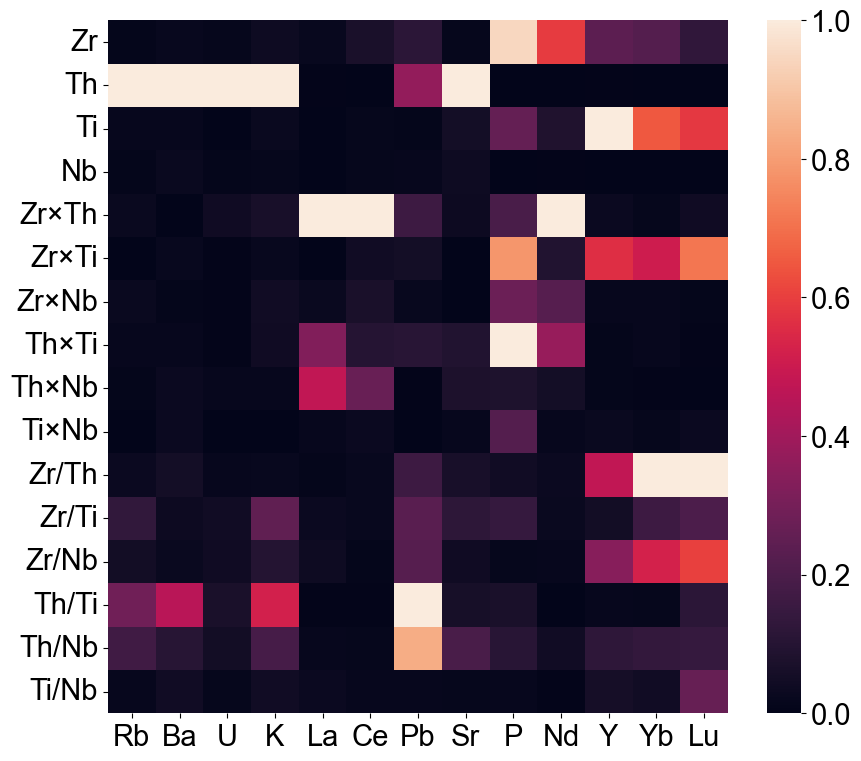

Already exist or fail to make dirs


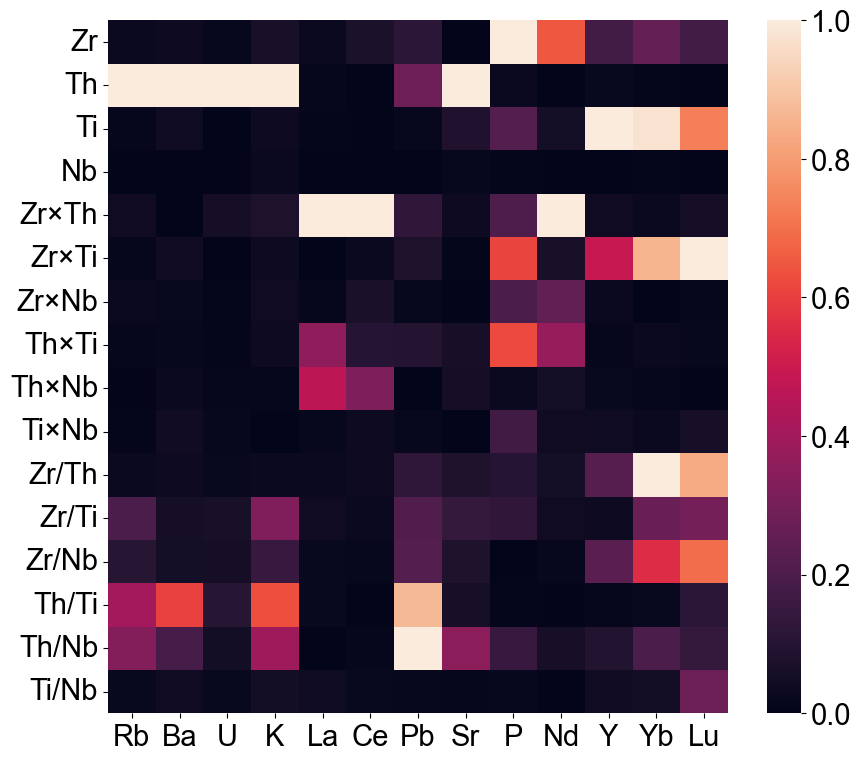

Already exist or fail to make dirs


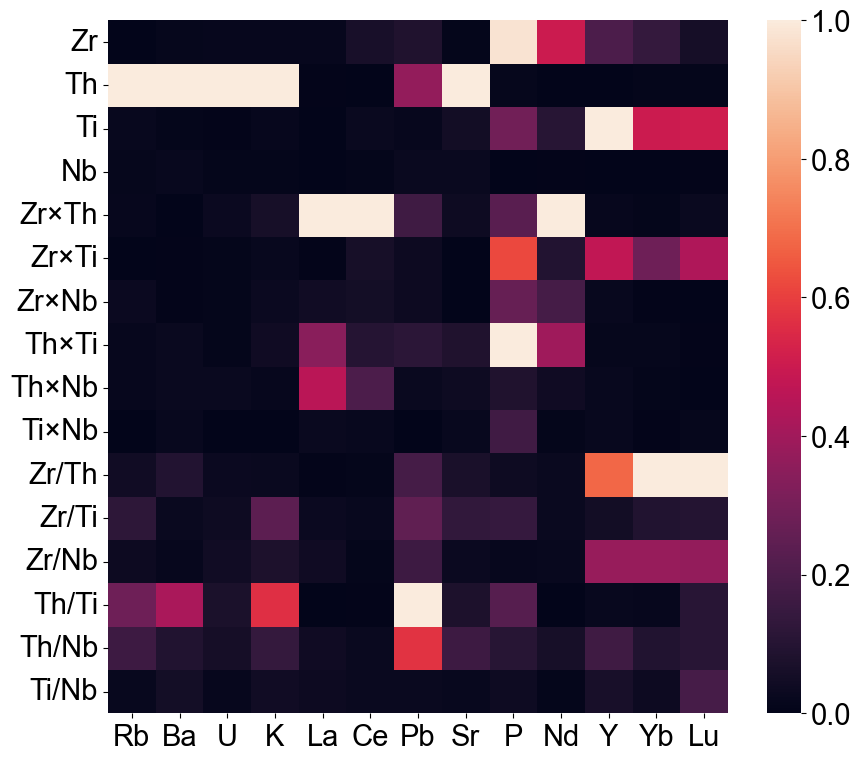

Already exist or fail to make dirs


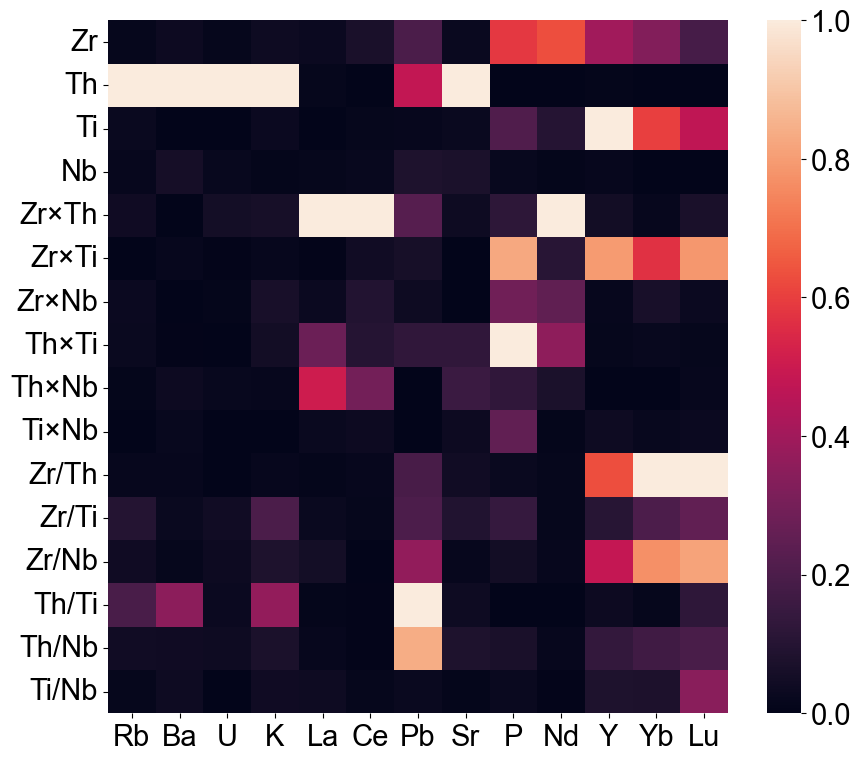

Already exist or fail to make dirs


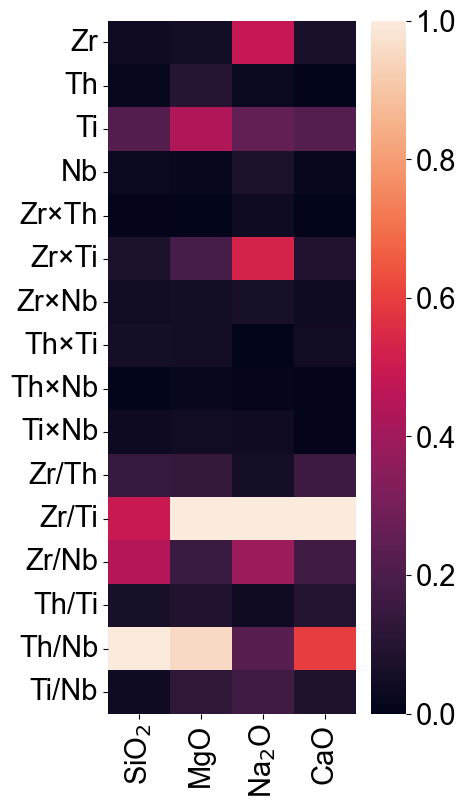

Already exist or fail to make dirs


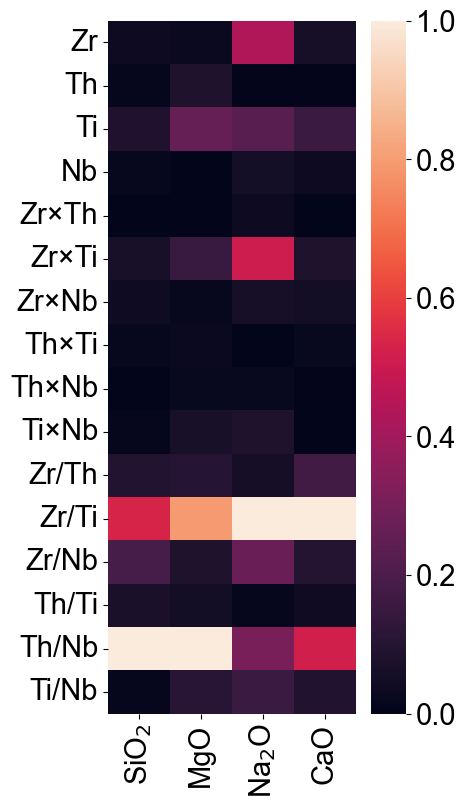

Already exist or fail to make dirs


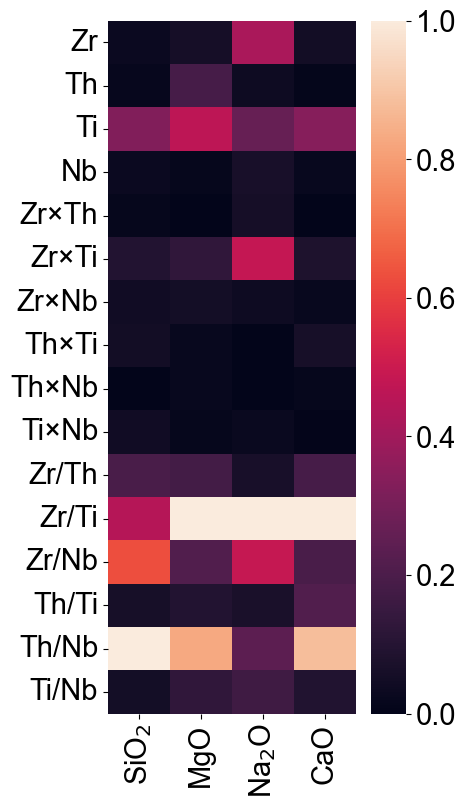

Already exist or fail to make dirs


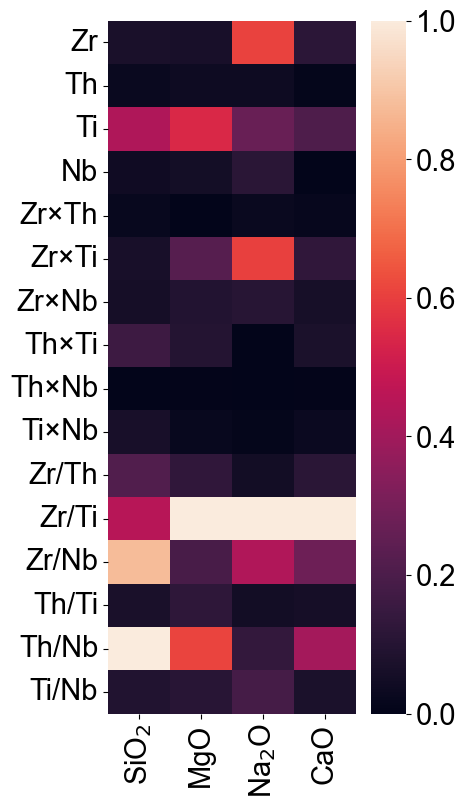

Model_interpletation
Already exist or fail to make dirs


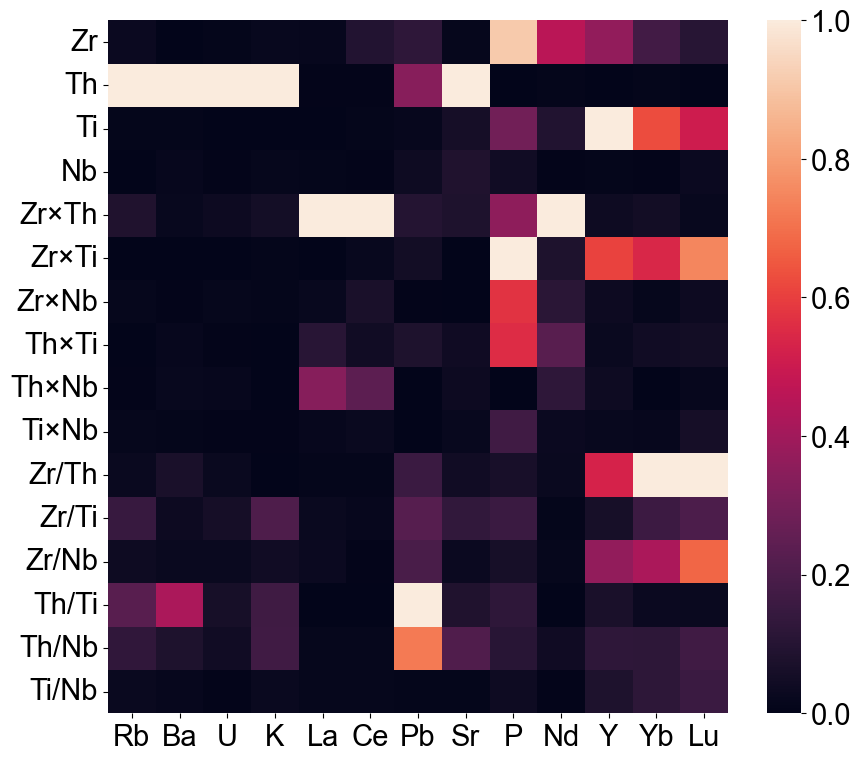

Already exist or fail to make dirs


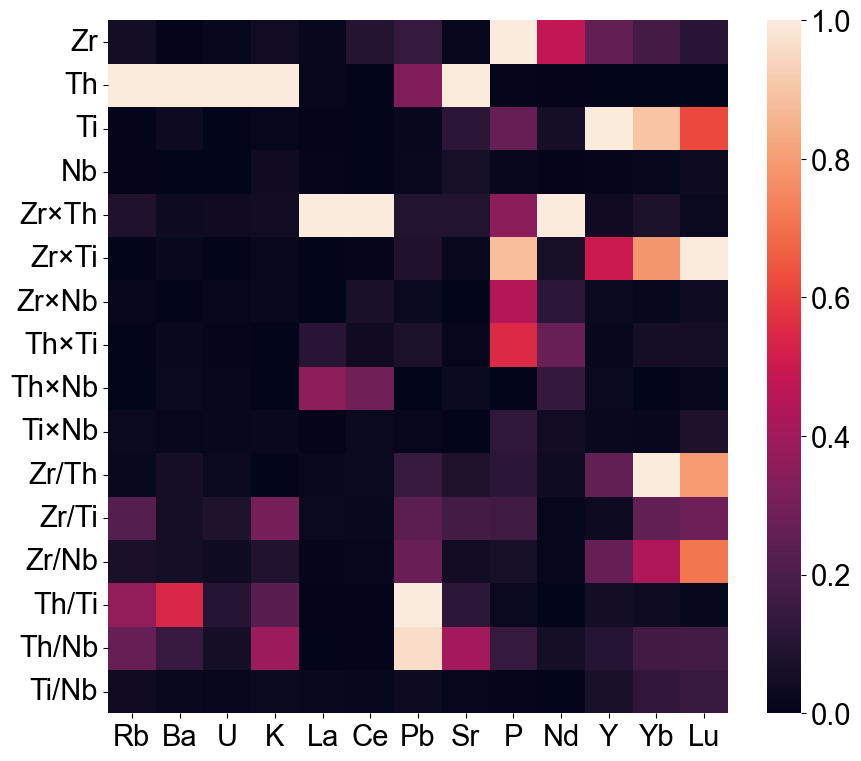

Already exist or fail to make dirs


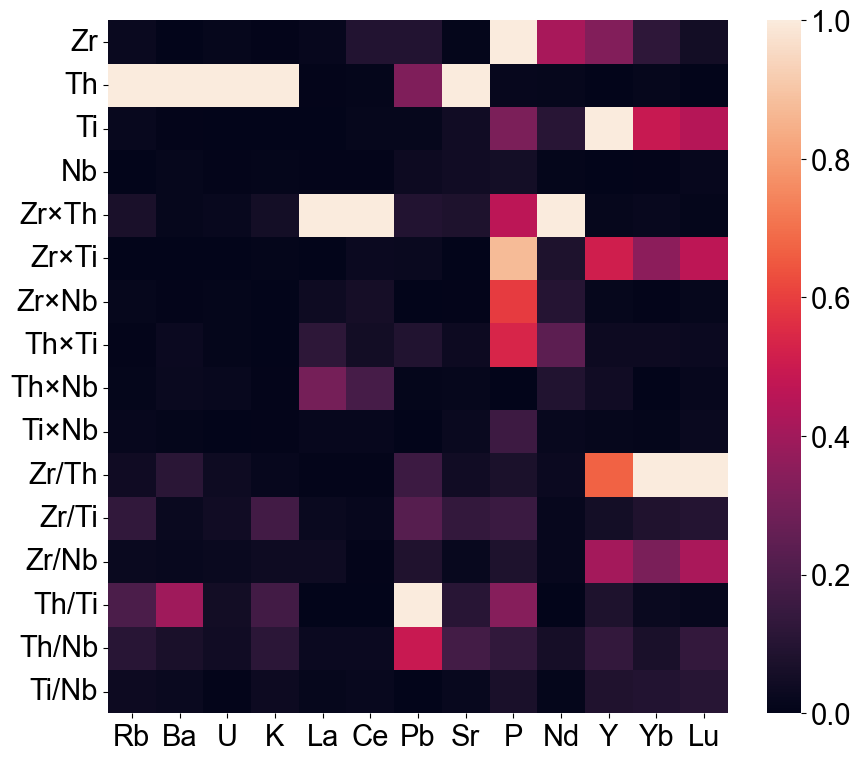

Already exist or fail to make dirs


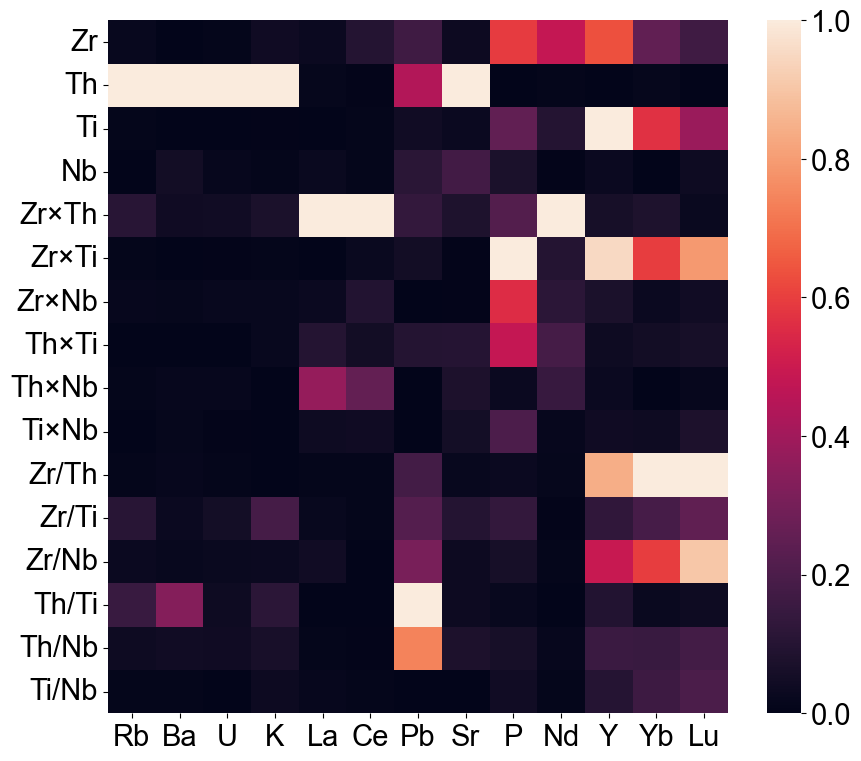

Already exist or fail to make dirs


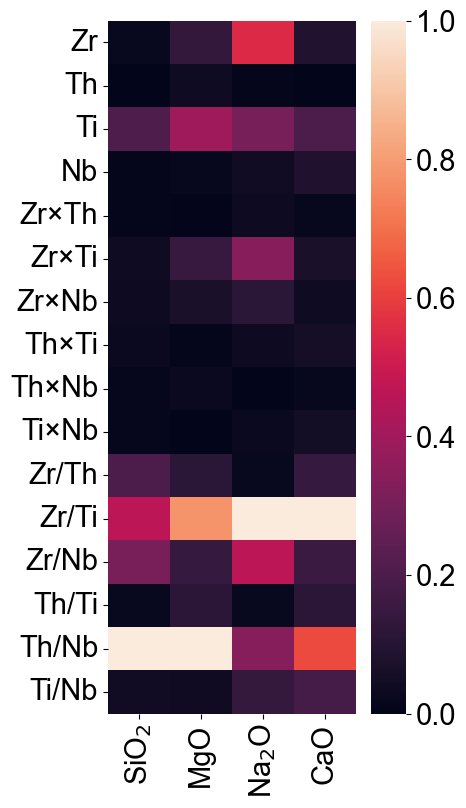

Already exist or fail to make dirs


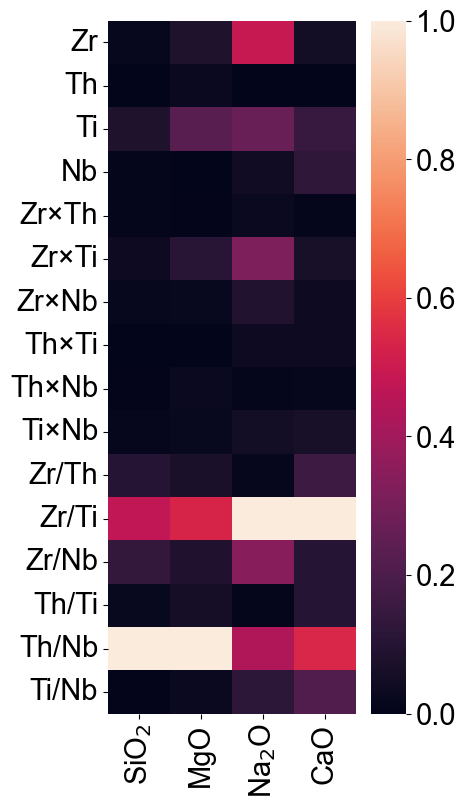

Already exist or fail to make dirs


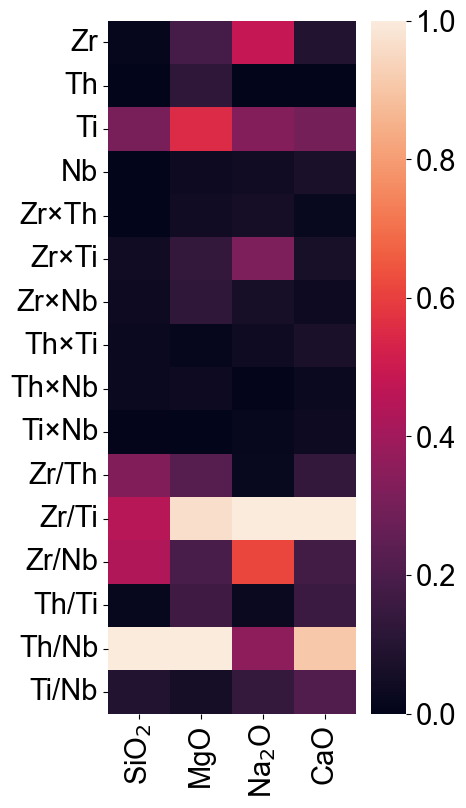

Already exist or fail to make dirs


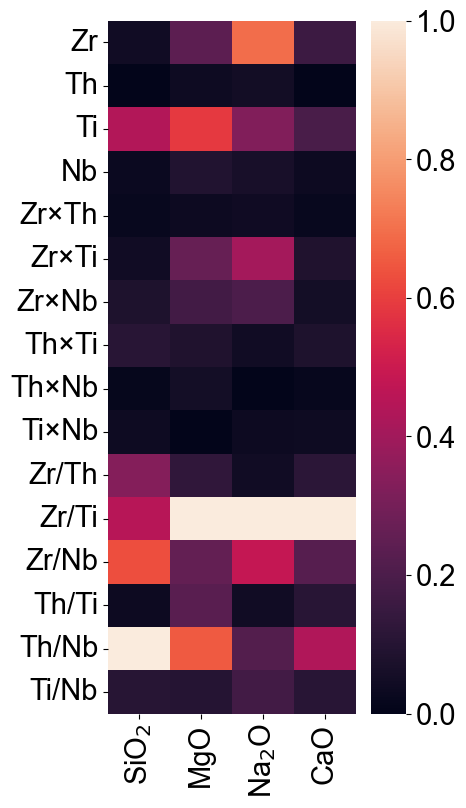

Model_interpletation
Already exist or fail to make dirs


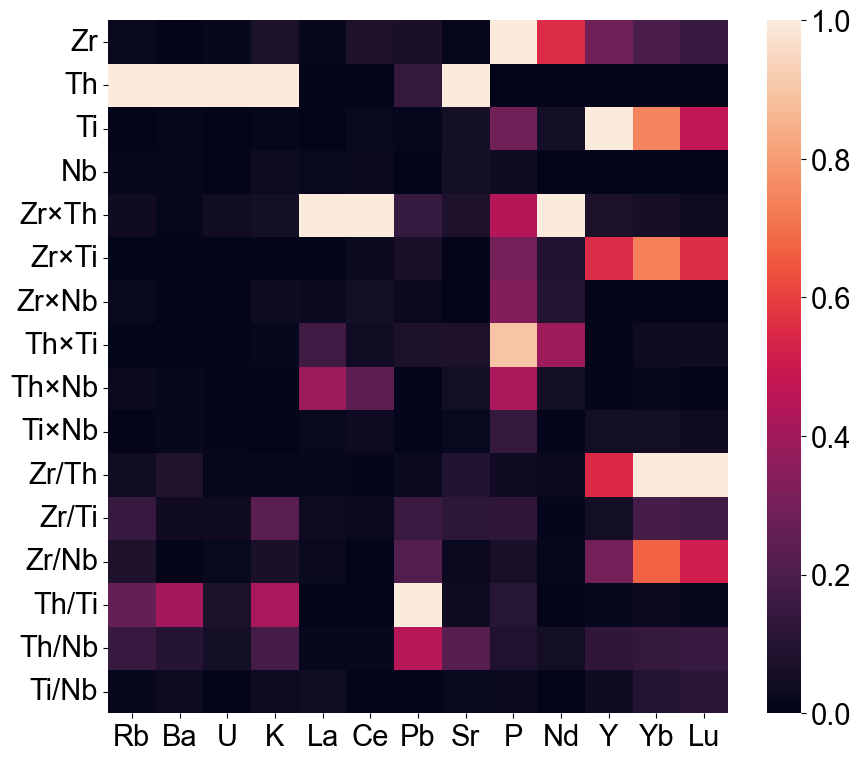

Already exist or fail to make dirs


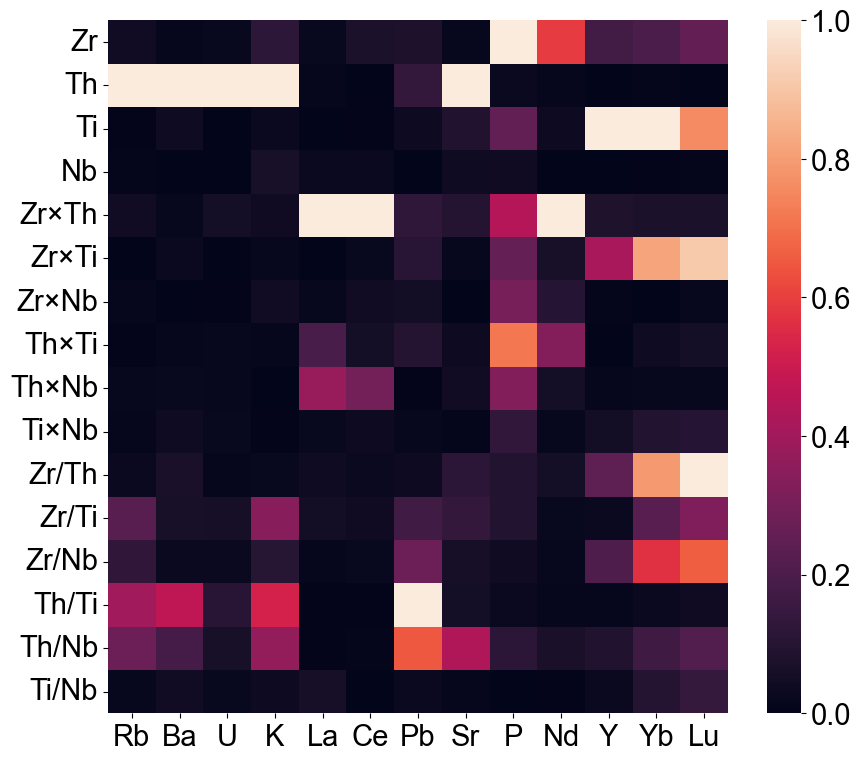

Already exist or fail to make dirs


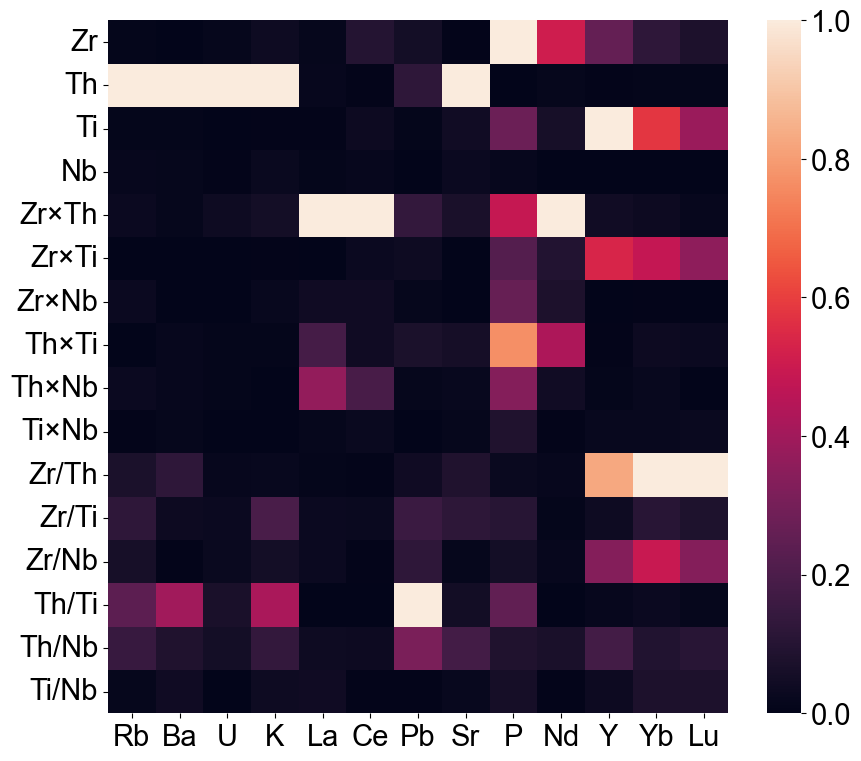

Already exist or fail to make dirs


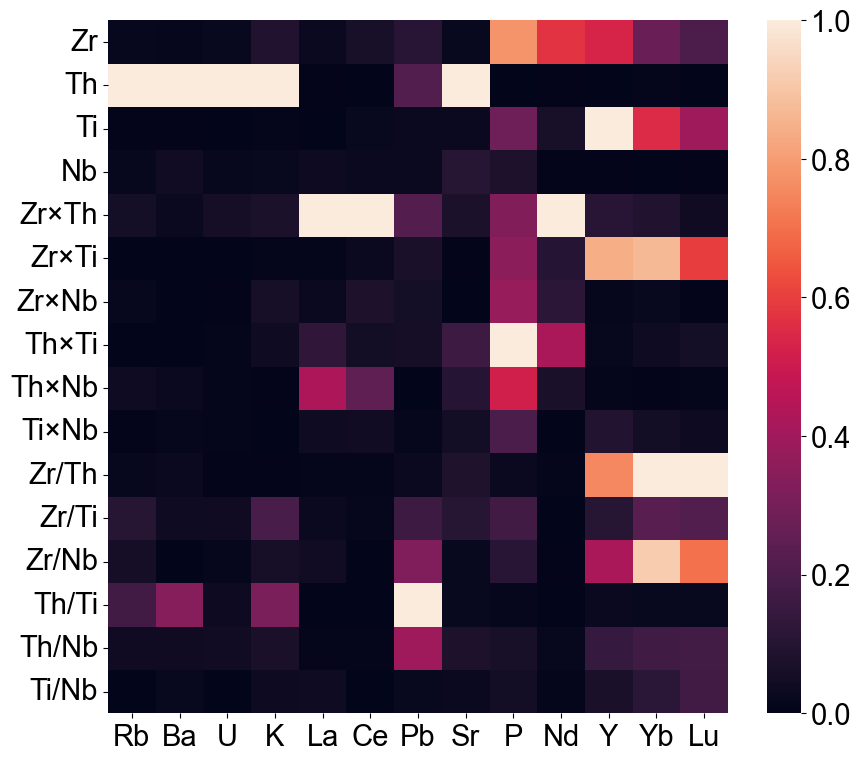

Already exist or fail to make dirs


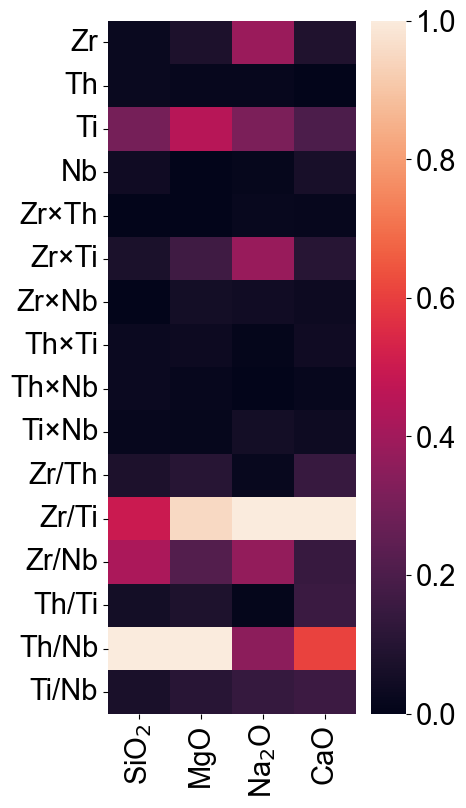

Already exist or fail to make dirs


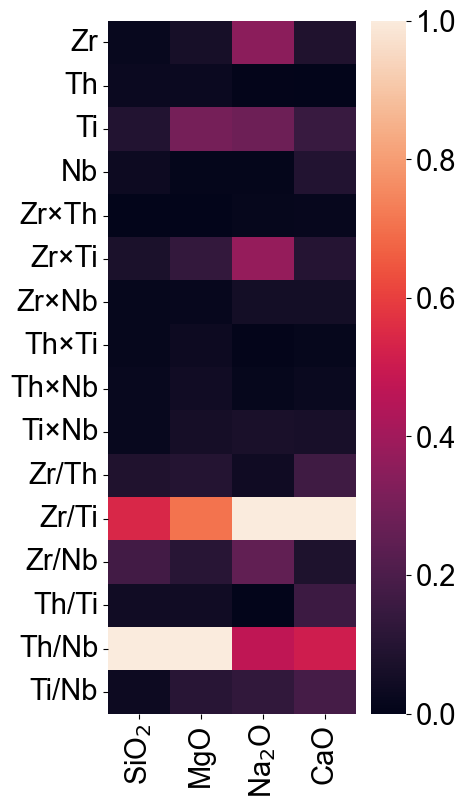

Already exist or fail to make dirs


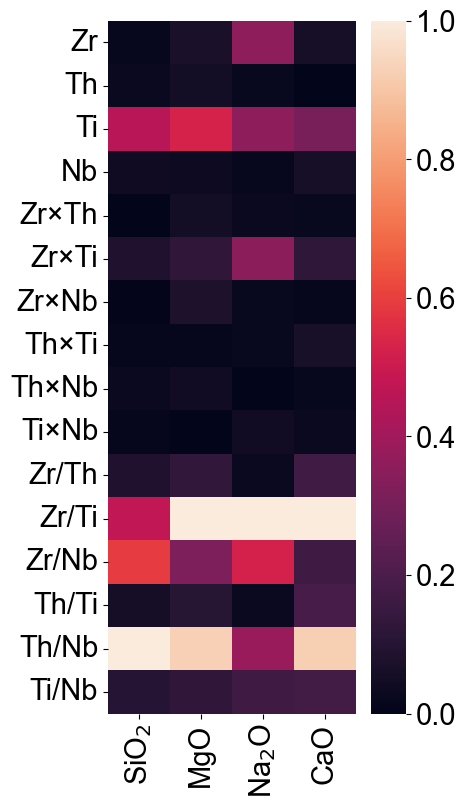

Already exist or fail to make dirs


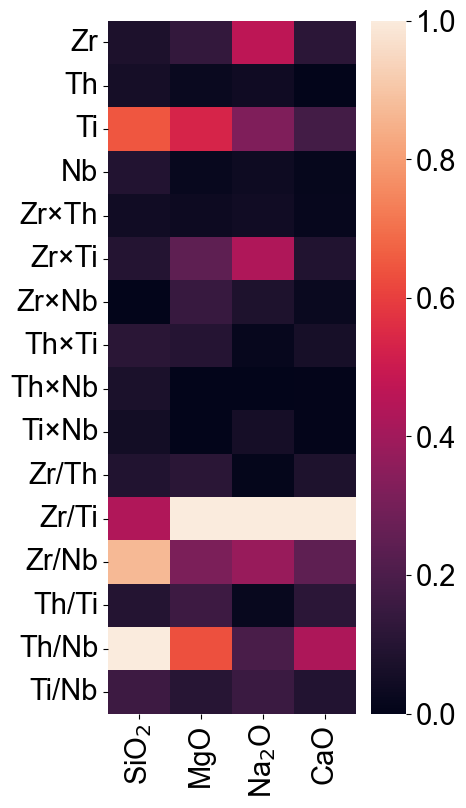

Model_interpletation
Already exist or fail to make dirs


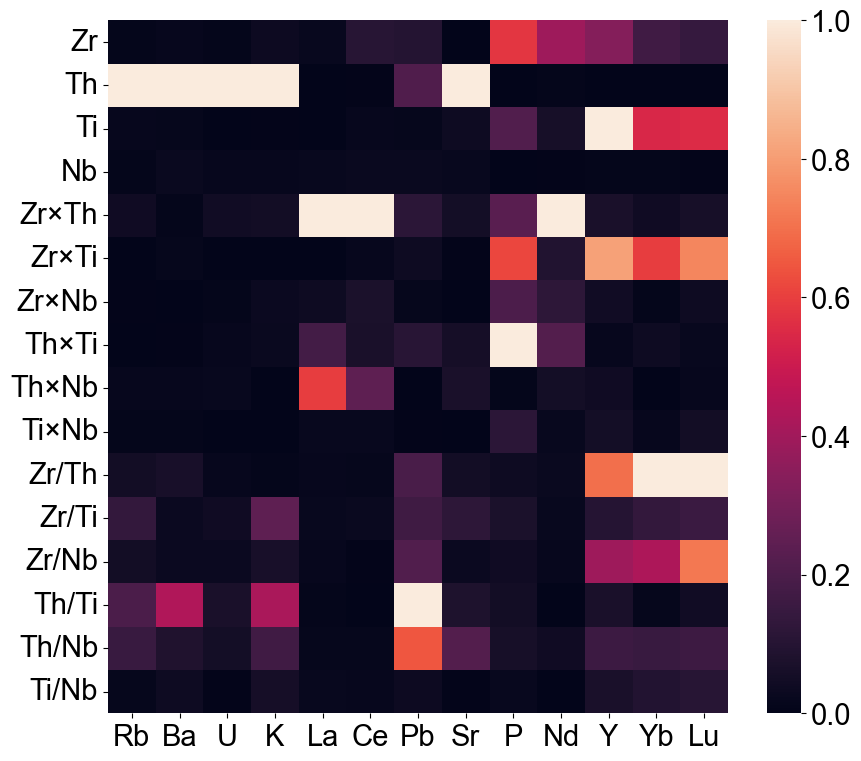

Already exist or fail to make dirs


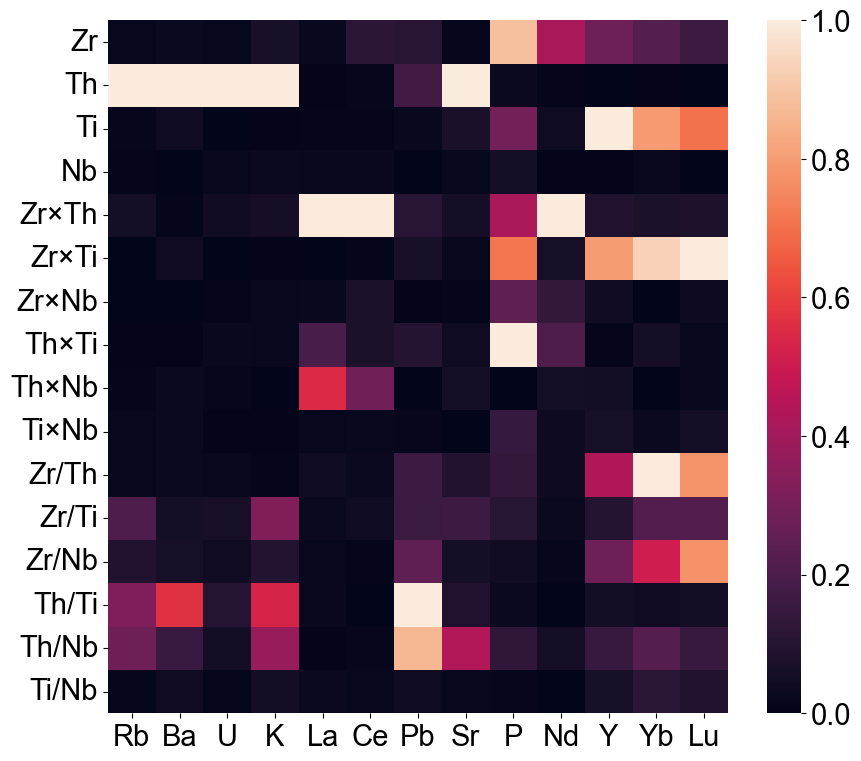

Already exist or fail to make dirs


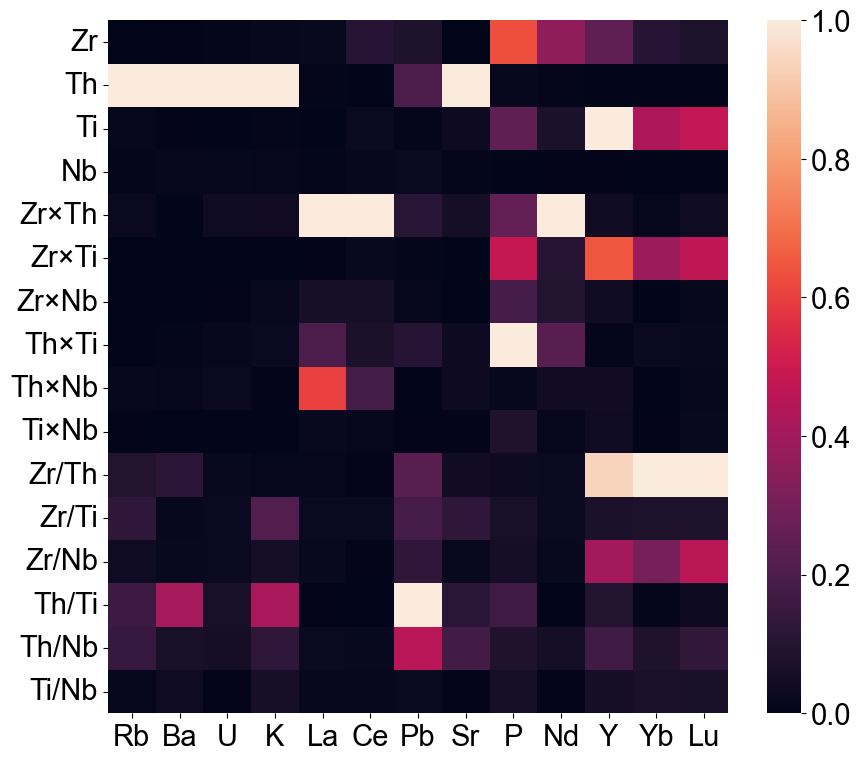

Already exist or fail to make dirs


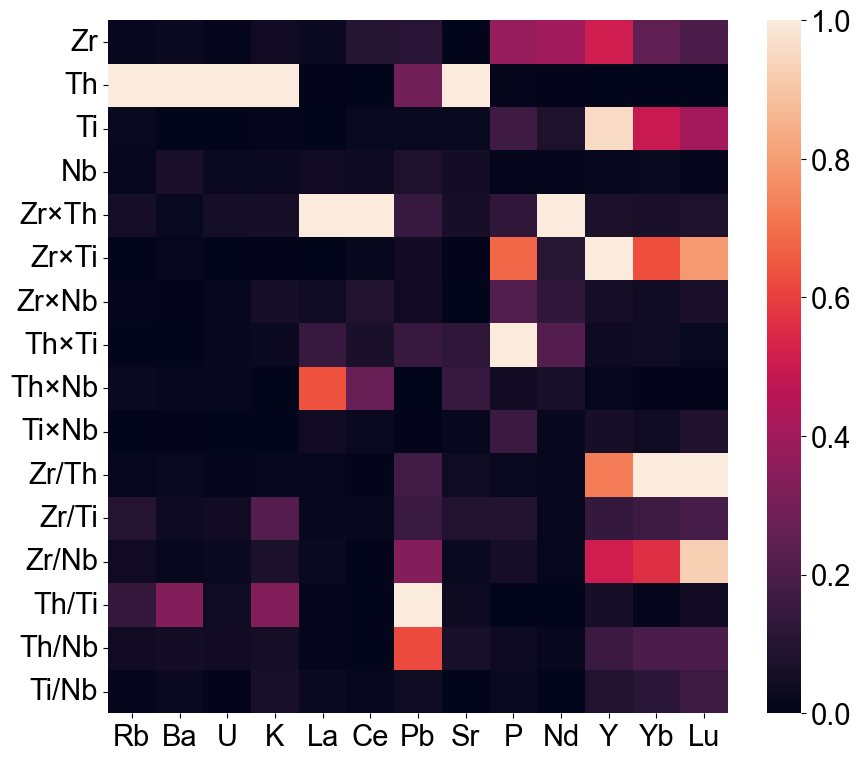

Already exist or fail to make dirs


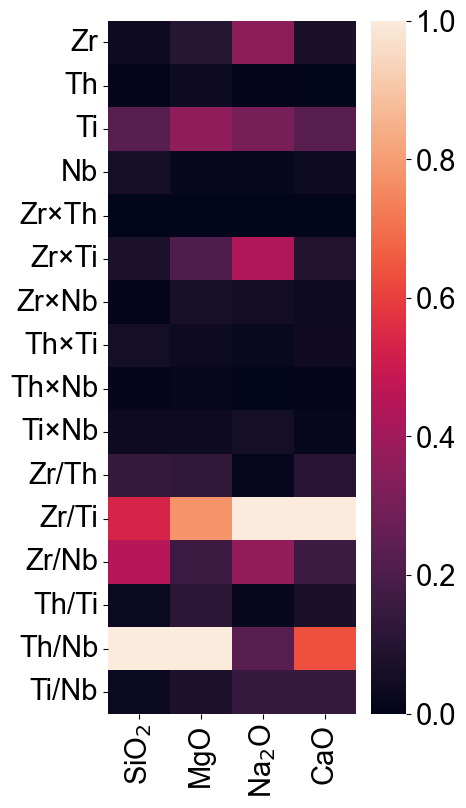

Already exist or fail to make dirs


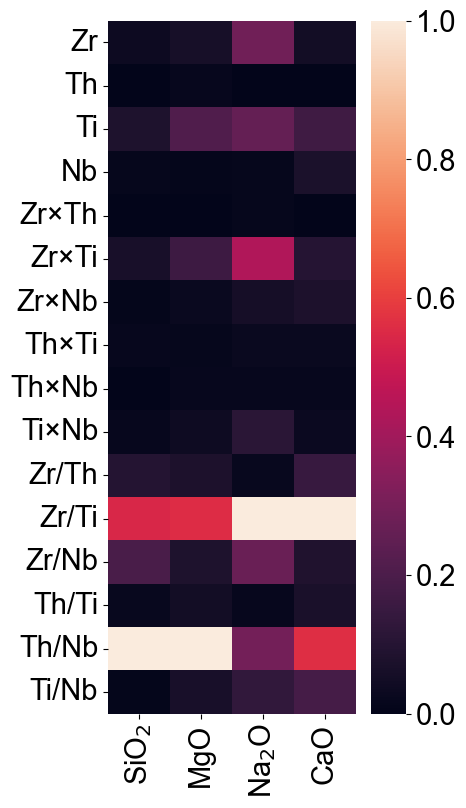

Already exist or fail to make dirs


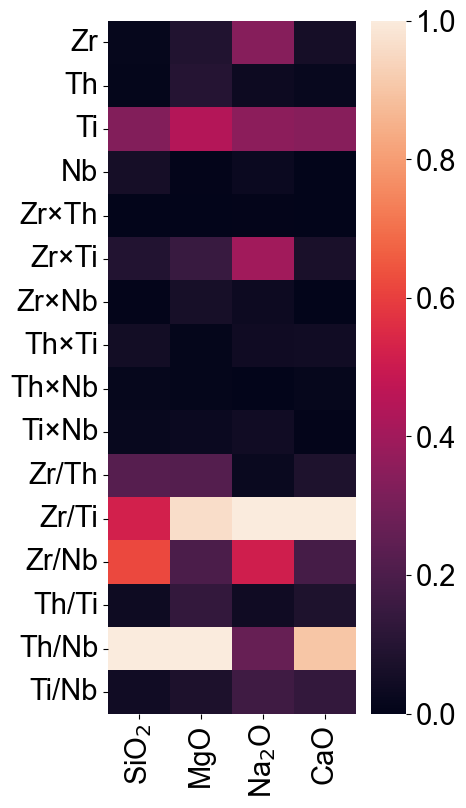

Already exist or fail to make dirs


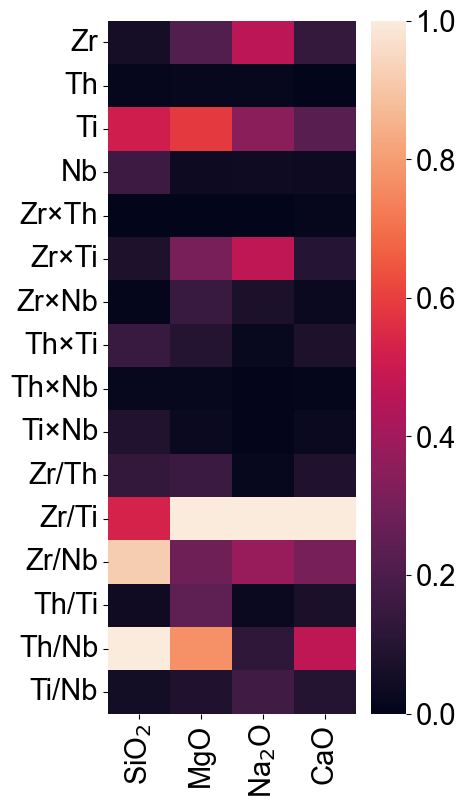

In [16]:
############### SHAP valueの正規化（MinMax）
elem_USE_minor = ['Rb', 'Ba', 'U', 'K', 'La', 'Ce', 'Pb', 'Sr', 'P', 'Nd', 'Y', 'Yb', 'Lu']
#elem_USE = ["TiO2_",  "Nb_", "Zr_", "Y_","Th_", "SiO2", 'Al2O3', "K2O", 'Rb', 'Ba', 'Pb', 'Sr']

#elem_USE = ['SiO2', 'Al2O3', 'MgO', 'Na2O', 'MnO', 'FeO']
elem_USE_major = ['SiO2', 'MgO', 'Na2O', 'CaO']
elem_USE_latex_major = [to_latex(label) for label in elem_USE_major]

#########################################################################################################
#
# Compile SHAP value to evaluate importance
# Visualize for each model result
# Update 2025/06/02
#
#########################################################################################################
for num in range(Fold_num):
    SHAP_minmax_Compile = pd.DataFrame()
    SHAP_minmax_Compile_VOLCANIC_ARC = pd.DataFrame()
    SHAP_minmax_Compile_SPREADING_CENTER = pd.DataFrame()
    SHAP_minmax_Compile_OCEAN_ISLAND = pd.DataFrame()
    
    #for elem_path in elem_path_list:
    for elem_path in elem_path_list:
        elem = elem_path.split("/")[-1]
        if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
            print(elem)
        else:
            # read data
            SHAP_Values=pd.read_excel(figure_folder_SHAP_importance+"/SHAP_Value/SHAP_Value_"+ elem + "_" + str(num) +".xlsx", index_col=0, header=0)
            # input name rename * → x (e.g., Th*Ti → Th x Tiに修正)
            col_input_name = SHAP_Values.columns # colの抽出
            col_input_name = col_input_name.str.replace("*", "×") # データの修正
            SHAP_Values.columns = col_input_name
            
            # 必要データの抽出
            SHAP_Values_columns=SHAP_Values.columns[:-1]
            SHAP_Values_Tec_col = SHAP_Values.columns[-1]
            Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique() # tectonic settingでuniqueを抽出
            
            # 必要な部分のみを取り出し、importanceを計算
            SHAP_importance = SHAP_Values[SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance - min_value) / (max_value - min_value)
            SHAP_minmax_Compile[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "VOLCANIC_ARC"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_VOLCANIC_ARC[elem] = SHAP_minmax
     
            # テクトニクスごとに計算
            Tec_now = "SPREADING_CENTER"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_SPREADING_CENTER[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "OCEAN_ISLAND"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_OCEAN_ISLAND[elem] = SHAP_minmax
    
    ############### SHAP valueの正規化（MinMax）
    
    #########################################################################################################
    #
    # Minor element 
    #
    #########################################################################################################
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile[elem_USE_minor], ax=ax)
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/ALL_SHAP" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_minor], ax=ax)
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_minor], ax=ax)
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/MORB_SHAP" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_minor], ax=ax)
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/OIB_SHAP" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()

    
    #########################################################################################################
    #
    # Major element 
    #
    #########################################################################################################
    ###################################################################################### ALL version ver 240511
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile[elem_USE_major], ax=ax)
    # x軸のラベルを LaTeX フォーマットに設定
    ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/ALL_SHAP_" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_major], ax=ax)
    # x軸のラベルを LaTeX フォーマットに設定
    ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP_" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_major], ax=ax)
    # x軸のラベルを LaTeX フォーマットに設定
    ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/MORB_SHAP_" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    
    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_major], ax=ax)
    # x軸のラベルを LaTeX フォーマットに設定
    ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
    # Savefig
    make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/OIB_SHAP_" + "_" + str(num) + ".pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()
    ###################################################################################### ALL version ver 240511

Model_interpletation
Model_interpletation
Model_interpletation
Model_interpletation
Already exist or fail to make dirs


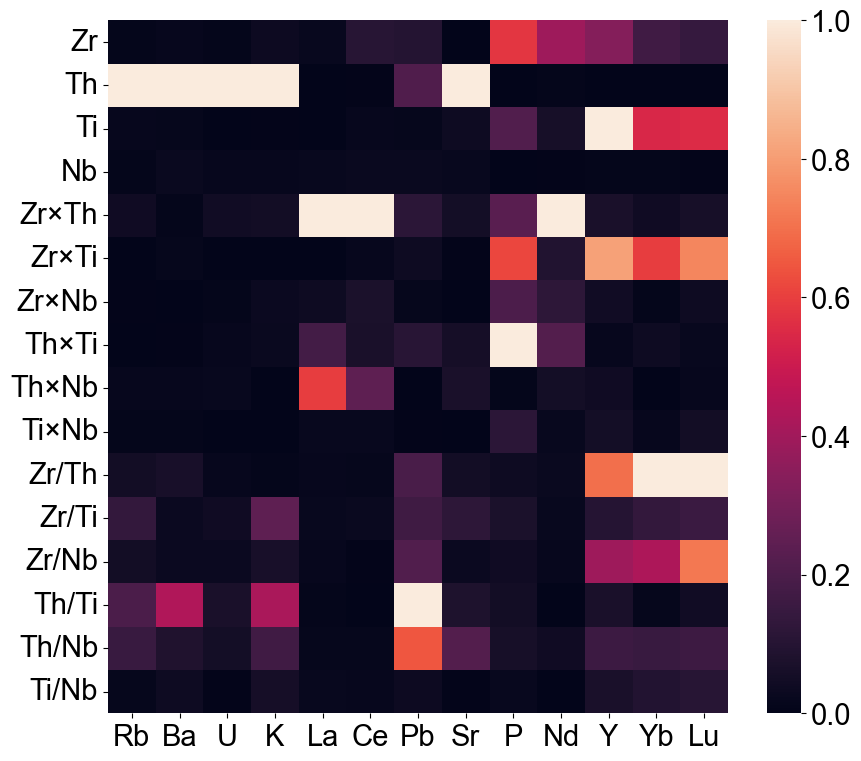

Already exist or fail to make dirs


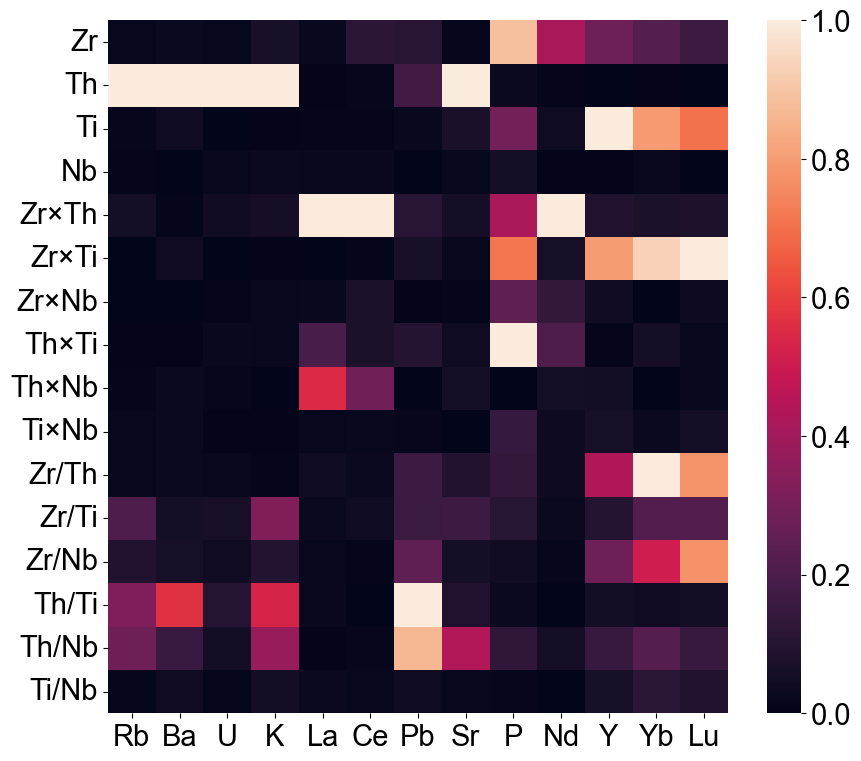

Already exist or fail to make dirs


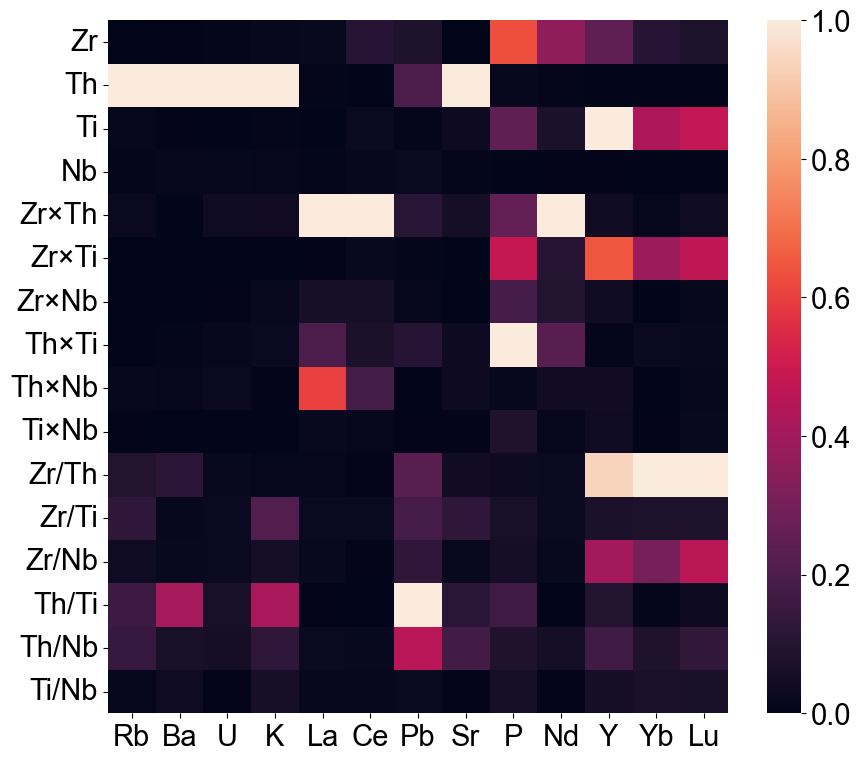

Already exist or fail to make dirs


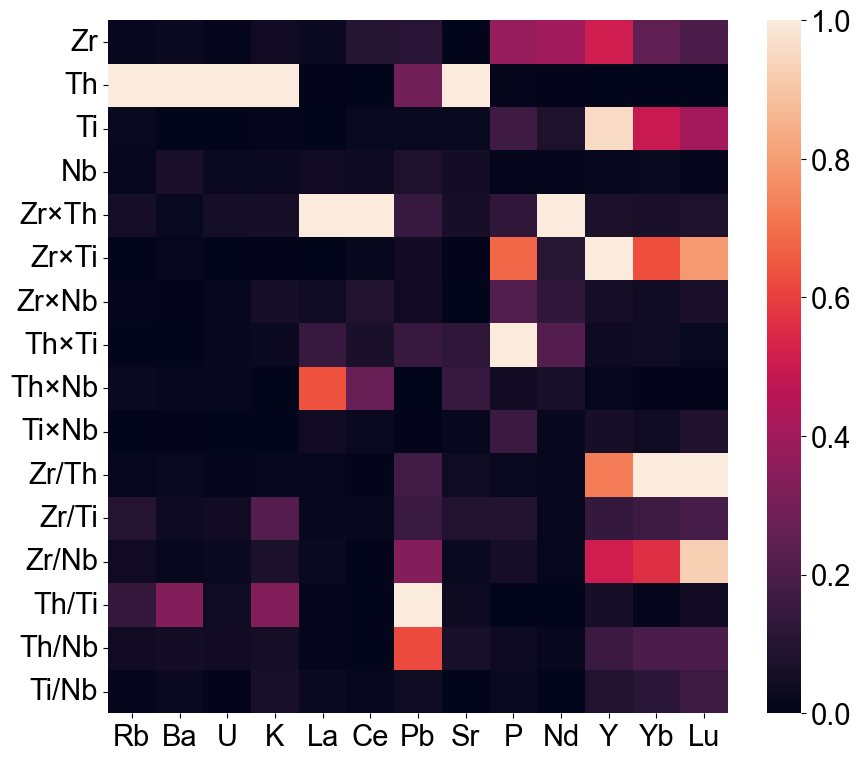

Already exist or fail to make dirs


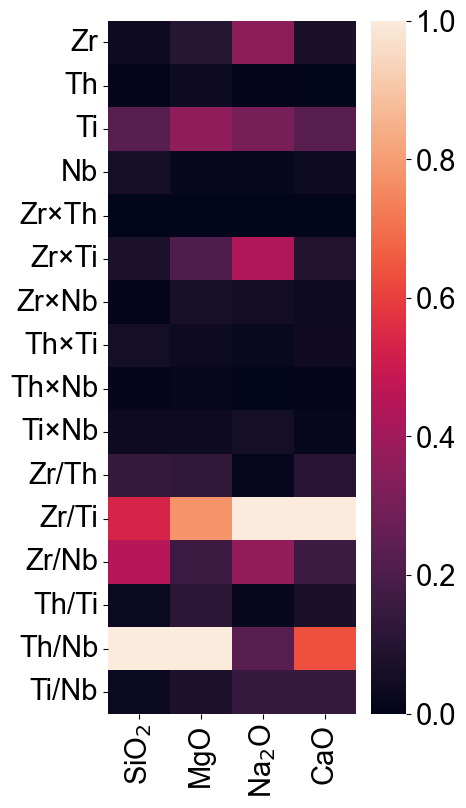

Already exist or fail to make dirs


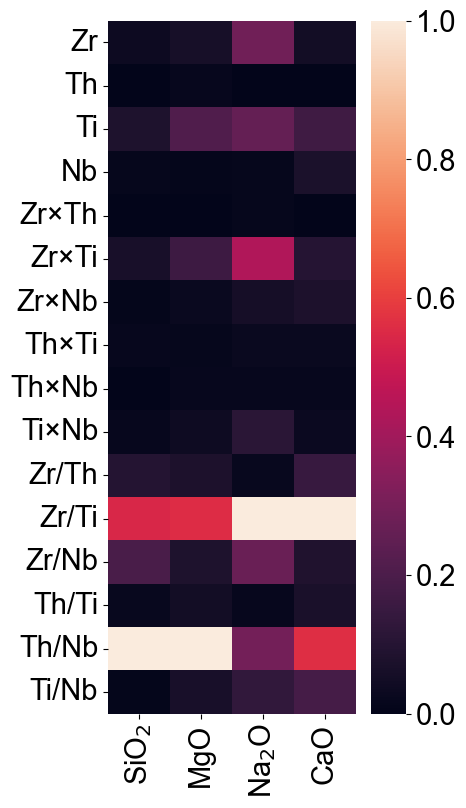

Already exist or fail to make dirs


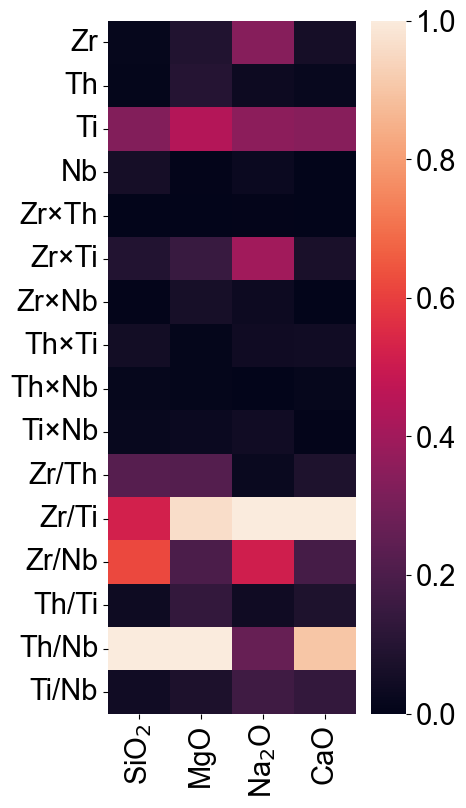

Already exist or fail to make dirs


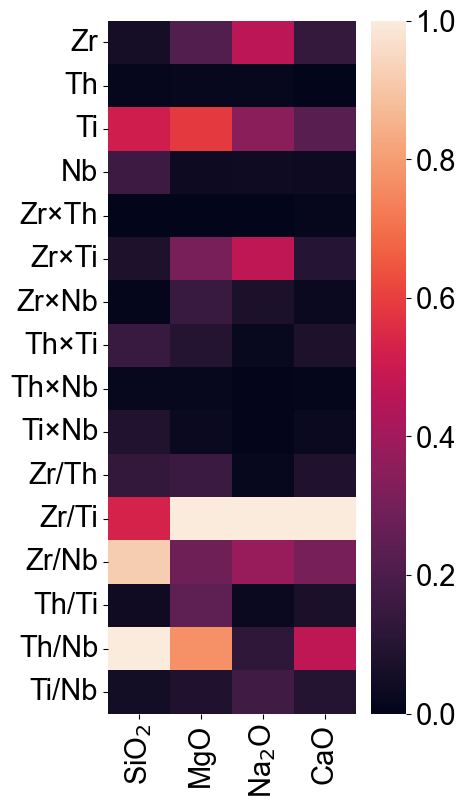

In [17]:
SHAP_minmax_Compile_ave = []
SHAP_minmax_Compile_VOLCANIC_ARC_ave = []
SHAP_minmax_Compile_SPREADING_CENTER_ave = []
SHAP_minmax_Compile_OCEAN_ISLAND_ave = []

#########################################################################################################
#
# Compile SHAP value to evaluate importance
# Visualize for ave. result
# Update 2025/06/02
#
#########################################################################################################

for num in range(Fold_num):
    SHAP_minmax_Compile = pd.DataFrame()
    SHAP_minmax_Compile_VOLCANIC_ARC = pd.DataFrame()
    SHAP_minmax_Compile_SPREADING_CENTER = pd.DataFrame()
    SHAP_minmax_Compile_OCEAN_ISLAND = pd.DataFrame()
    
    #for elem_path in elem_path_list:
    for elem_path in elem_path_list:
        elem = elem_path.split("/")[-1]
        if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
            print(elem)
        else:
            # read data
            SHAP_Values=pd.read_excel(figure_folder_SHAP_importance+"/SHAP_Value/SHAP_Value_"+ elem + "_" + str(num) +".xlsx", index_col=0, header=0)
            # input name rename * → x (e.g., Th*Ti → Th x Tiに修正)
            col_input_name = SHAP_Values.columns # colの抽出
            col_input_name = col_input_name.str.replace("*", "×") # データの修正
            SHAP_Values.columns = col_input_name
            
            # 必要データの抽出
            SHAP_Values_columns=SHAP_Values.columns[:-1]
            SHAP_Values_Tec_col = SHAP_Values.columns[-1]
            Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique() # tectonic settingでuniqueを抽出
            
            # 必要な部分のみを取り出し、importanceを計算
            SHAP_importance = SHAP_Values[SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance - min_value) / (max_value - min_value)
            SHAP_minmax_Compile[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "VOLCANIC_ARC"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_VOLCANIC_ARC[elem] = SHAP_minmax
     
            # テクトニクスごとに計算
            Tec_now = "SPREADING_CENTER"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_SPREADING_CENTER[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "OCEAN_ISLAND"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = ( SHAP_importance_Tec - min_value) / (max_value - min_value)
            SHAP_minmax_Compile_OCEAN_ISLAND[elem] = SHAP_minmax

    ######
    SHAP_minmax_Compile_ave.append(SHAP_minmax_Compile)
    SHAP_minmax_Compile_VOLCANIC_ARC_ave.append(SHAP_minmax_Compile_VOLCANIC_ARC)
    SHAP_minmax_Compile_SPREADING_CENTER_ave.append(SHAP_minmax_Compile_SPREADING_CENTER)
    SHAP_minmax_Compile_OCEAN_ISLAND_ave.append(SHAP_minmax_Compile_OCEAN_ISLAND)

#########################################################################################################
#
# Average result of global SHAP 
#
#########################################################################################################
average_SHAP_minmax_Compile = pd.concat(SHAP_minmax_Compile_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_VOLCANIC_ARC = pd.concat(SHAP_minmax_Compile_VOLCANIC_ARC_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_SPREADING_CENTER = pd.concat(SHAP_minmax_Compile_SPREADING_CENTER_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_OCEAN_ISLAND = pd.concat(SHAP_minmax_Compile_OCEAN_ISLAND_ave).groupby(level=0).mean()
#########################################################################################################
#
# Minor element 
#
#########################################################################################################

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/ALL_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/MORB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/OIB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()


#########################################################################################################
#
# Major element 
#
#########################################################################################################
###################################################################################### ALL version ver 240511
# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/ALL_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/MORB_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/OIB_SHAP_" + "_" + "ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()
###################################################################################### ALL version ver 240511

Model_interpletation
Model_interpletation
Model_interpletation
Model_interpletation
Already exist or fail to make dirs


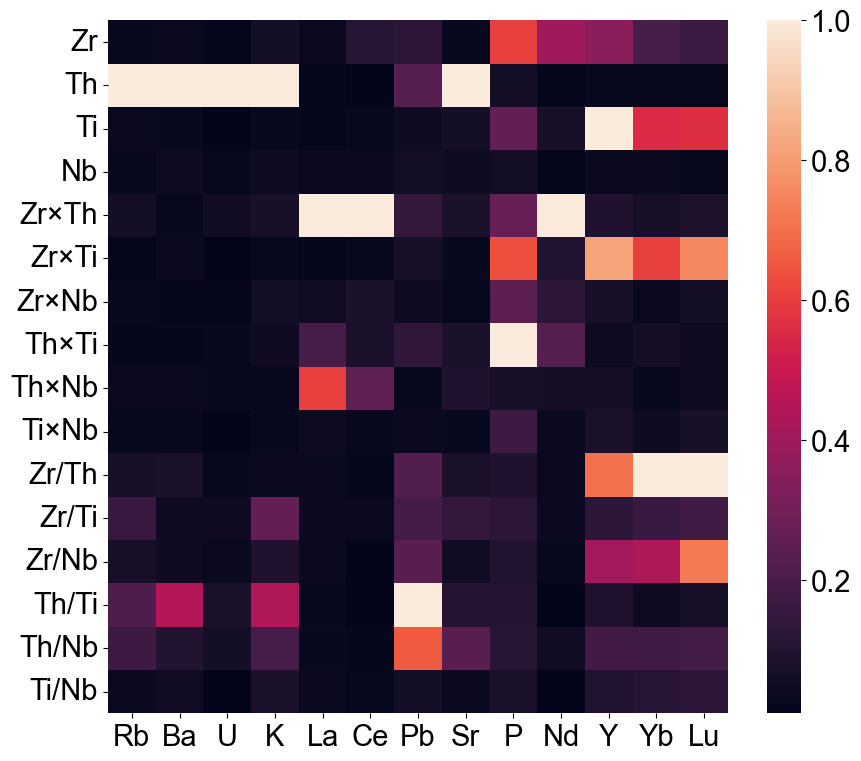

Already exist or fail to make dirs


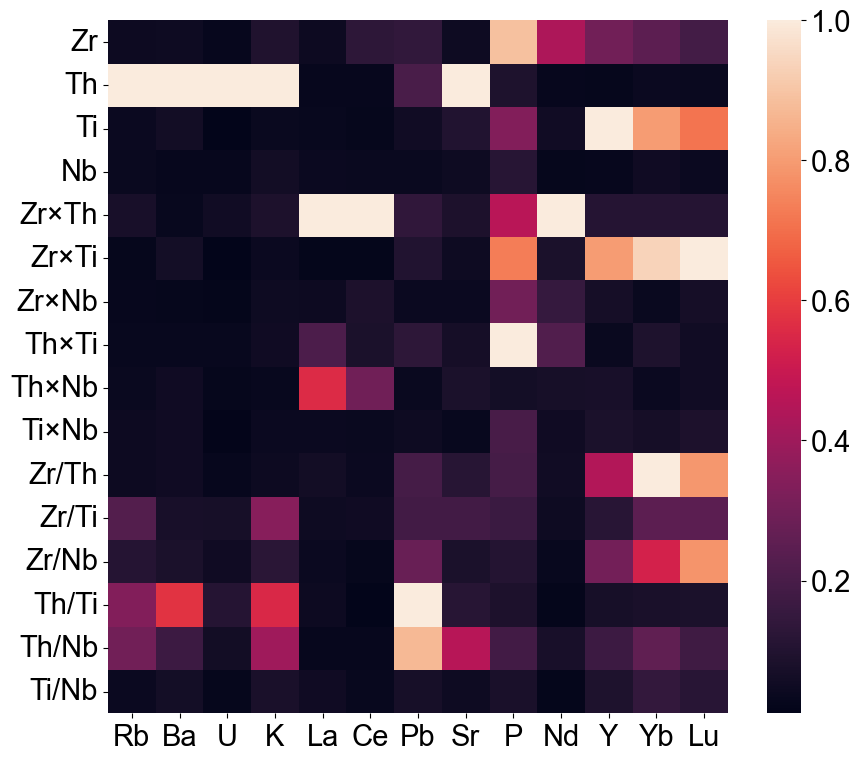

Already exist or fail to make dirs


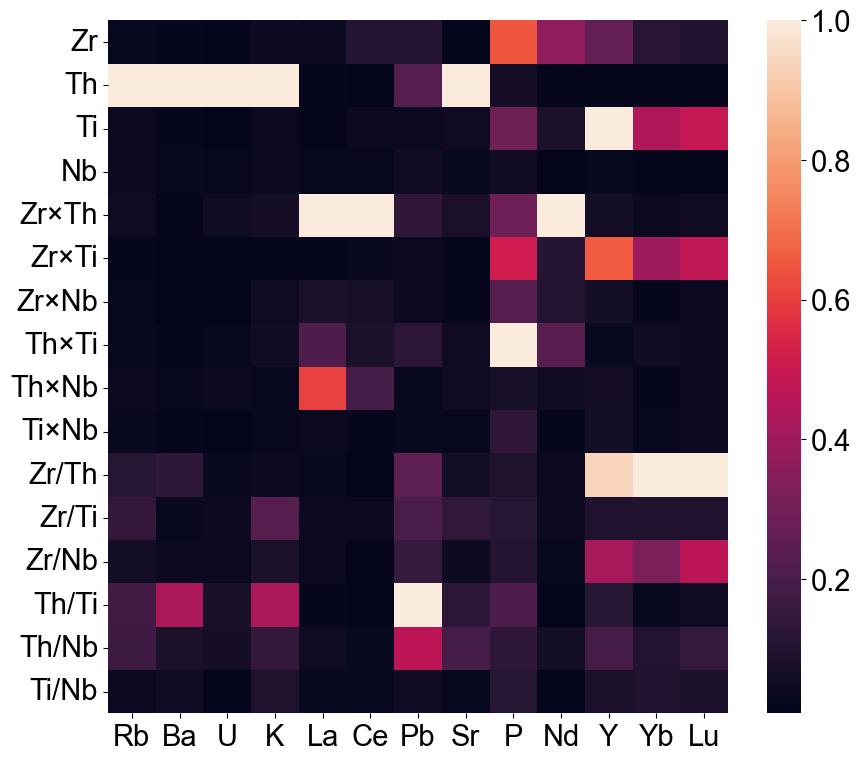

Already exist or fail to make dirs


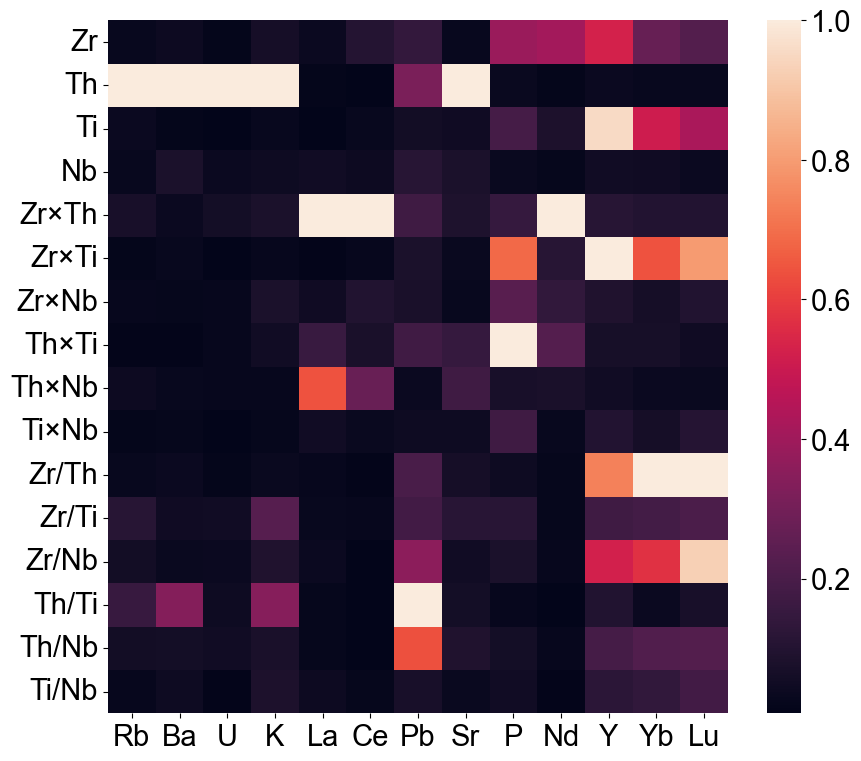

Already exist or fail to make dirs


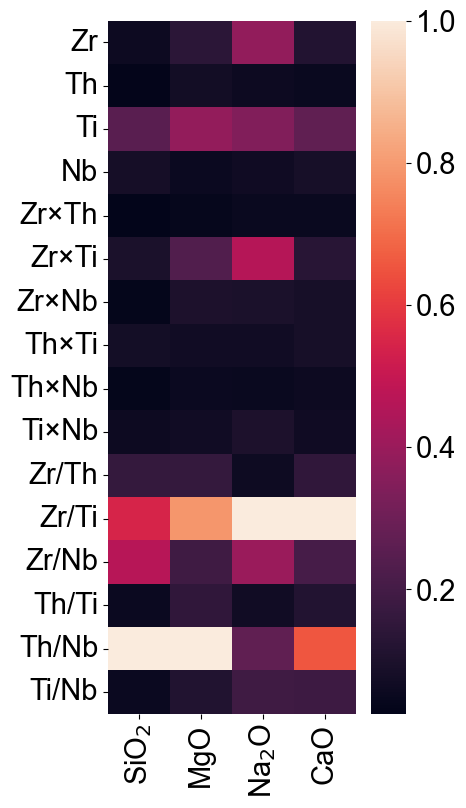

Already exist or fail to make dirs


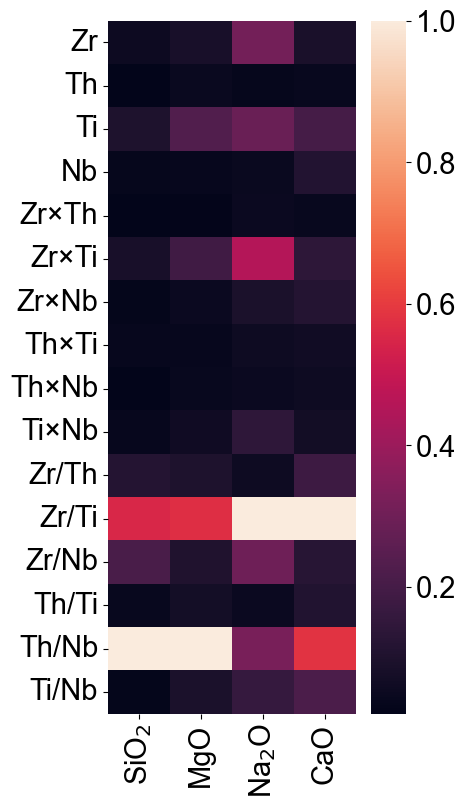

Already exist or fail to make dirs


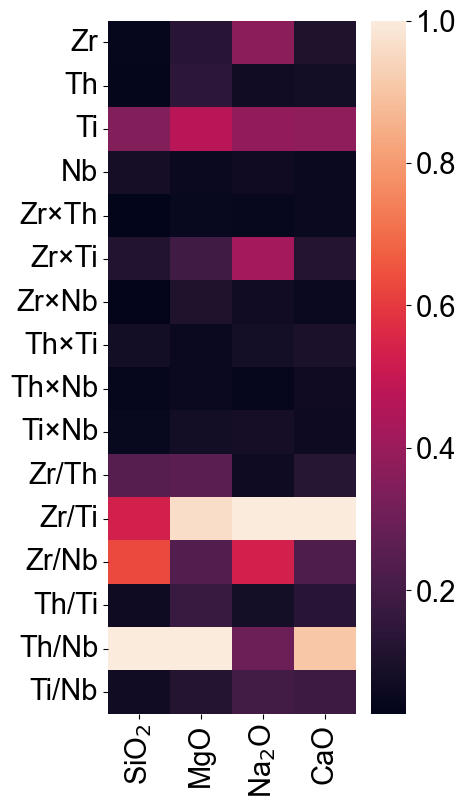

Already exist or fail to make dirs


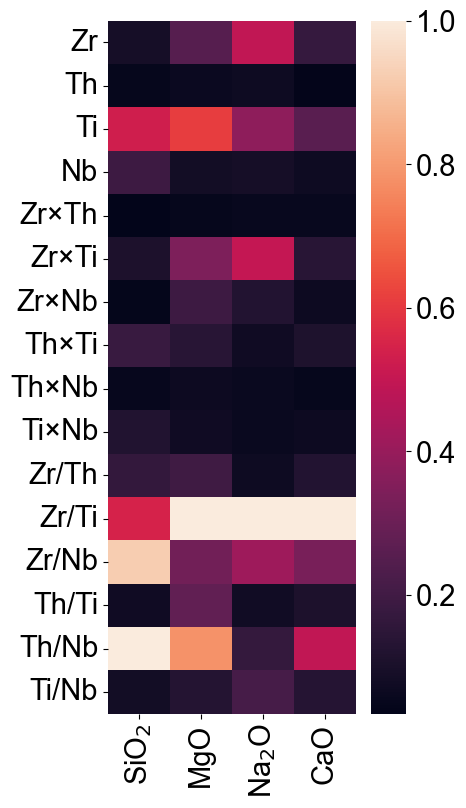

In [18]:
SHAP_minmax_Compile_ave = []
SHAP_minmax_Compile_VOLCANIC_ARC_ave = []
SHAP_minmax_Compile_SPREADING_CENTER_ave = []
SHAP_minmax_Compile_OCEAN_ISLAND_ave = []

#########################################################################################################
#
# Compile SHAP value to evaluate importance
# Visualize for ave. result
# Update 2025/06/02
#
#########################################################################################################

for num in range(Fold_num):
    SHAP_minmax_Compile = pd.DataFrame()
    SHAP_minmax_Compile_VOLCANIC_ARC = pd.DataFrame()
    SHAP_minmax_Compile_SPREADING_CENTER = pd.DataFrame()
    SHAP_minmax_Compile_OCEAN_ISLAND = pd.DataFrame()
    
    #for elem_path in elem_path_list:
    for elem_path in elem_path_list:
        elem = elem_path.split("/")[-1]
        if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
            print(elem)
        else:
            # read data
            SHAP_Values=pd.read_excel(figure_folder_SHAP_importance+"/SHAP_Value/SHAP_Value_"+ elem + "_" + str(num) +".xlsx", index_col=0, header=0)
            # input name rename * → x (e.g., Th*Ti → Th x Tiに修正)
            col_input_name = SHAP_Values.columns # colの抽出
            col_input_name = col_input_name.str.replace("*", "×") # データの修正
            SHAP_Values.columns = col_input_name
            
            # 必要データの抽出
            SHAP_Values_columns=SHAP_Values.columns[:-1]
            SHAP_Values_Tec_col = SHAP_Values.columns[-1]
            Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique() # tectonic settingでuniqueを抽出
            
            # 必要な部分のみを取り出し、importanceを計算
            SHAP_importance = SHAP_Values[SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance) / (max_value)
            SHAP_minmax_Compile[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "VOLCANIC_ARC"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = (SHAP_importance_Tec) / (max_value)
            SHAP_minmax_Compile_VOLCANIC_ARC[elem] = SHAP_minmax
     
            # テクトニクスごとに計算
            Tec_now = "SPREADING_CENTER"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = (SHAP_importance_Tec) / (max_value)
            SHAP_minmax_Compile_SPREADING_CENTER[elem] = SHAP_minmax
            
            # テクトニクスごとに計算
            Tec_now = "OCEAN_ISLAND"
            SHAP_importance_Tec = SHAP_Values[SHAP_Values[SHAP_Values_Tec_col] == Tec_now][SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance_Tec.min()
            max_value = SHAP_importance_Tec.max()
            SHAP_minmax = (SHAP_importance_Tec) / (max_value)
            SHAP_minmax_Compile_OCEAN_ISLAND[elem] = SHAP_minmax

    ######
    SHAP_minmax_Compile_ave.append(SHAP_minmax_Compile)
    SHAP_minmax_Compile_VOLCANIC_ARC_ave.append(SHAP_minmax_Compile_VOLCANIC_ARC)
    SHAP_minmax_Compile_SPREADING_CENTER_ave.append(SHAP_minmax_Compile_SPREADING_CENTER)
    SHAP_minmax_Compile_OCEAN_ISLAND_ave.append(SHAP_minmax_Compile_OCEAN_ISLAND)

#########################################################################################################
#
# Average result of global SHAP 
#
#########################################################################################################
average_SHAP_minmax_Compile = pd.concat(SHAP_minmax_Compile_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_VOLCANIC_ARC = pd.concat(SHAP_minmax_Compile_VOLCANIC_ARC_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_SPREADING_CENTER = pd.concat(SHAP_minmax_Compile_SPREADING_CENTER_ave).groupby(level=0).mean()
average_SHAP_minmax_Compile_OCEAN_ISLAND = pd.concat(SHAP_minmax_Compile_OCEAN_ISLAND_ave).groupby(level=0).mean()
#########################################################################################################
#
# Minor element 
#
#########################################################################################################

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_ALL_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_VAB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_MORB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(10, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_minor], ax=ax)
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_OIB_SHAP" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()


#########################################################################################################
#
# Major element 
#
#########################################################################################################
###################################################################################### ALL version ver 240511
# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_ALL_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_VOLCANIC_ARC[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_VAB_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_SPREADING_CENTER[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_MORB_SHAP_" + "_" + "_ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()

# 正方形の図を作成し、図のサイズを調整
fig, ax = plt.subplots(figsize=(4, 9))  # 図のサイズを8x8に設定
# sns.heatmapを使用してヒートマップを描画
sns.heatmap(SHAP_minmax_Compile_OCEAN_ISLAND[elem_USE_major], ax=ax)
# x軸のラベルを LaTeX フォーマットに設定
ax.set_xticklabels(elem_USE_latex_major, rotation=90, ha='center')  # 回転と位置調整
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
# Savefig
make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/0_OIB_SHAP_" + "_" + "ave.pdf", bbox_inches="tight")
# プロットを表示
plt.show()
###################################################################################### ALL version ver 240511

/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Correctly make dirs


/Users/satoshimatsuno/Library/Caches/pypoetry/virtualenvs/prm-application-main-_TzzqeMA-py3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


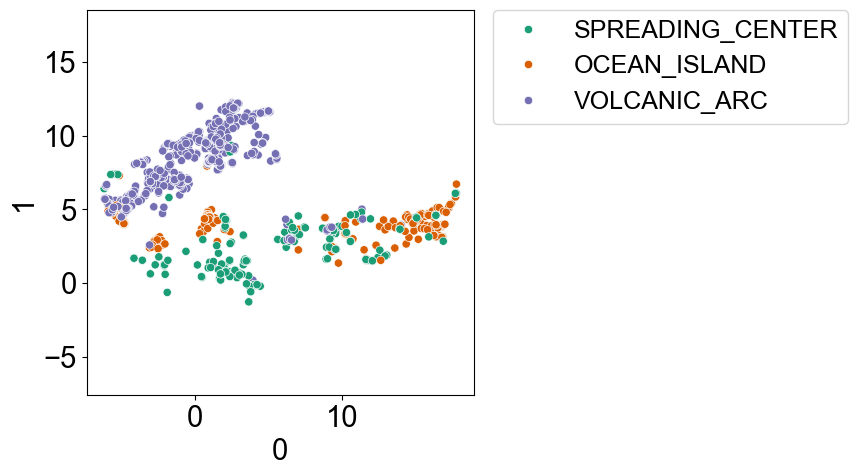

In [11]:
figure_folder_UMAP = path_all_train_data+"Model_interpletation/UMAP"

########################################################## UMAP Tectonic Setting
UMAP_data_RAW = pd.read_excel(path_all_train_data+"USE_DATA.xlsx")
data_train_setting = pd.read_excel(path_all_train_data+"/0_Protolith/Location_Ref_Data.xlsx")["SAMPLE_INFO"].loc[data_train.index]

#immobile_list = ["Zr", "Th", "Ti", "Nb"]
#immobile_list = ["Ti", "Nb", "Zr", "Y", "Th"]

#使うデータを抽出
UMAP_data = UMAP_data_RAW[immobile_list].copy().dropna().apply(lambda x: np.log10(x)) # 使用データ log変換

############################################## UMAP 処理 前処理→UMAP→Compile
#####前処理 ->標準化　平均0　分散1
SDS = StandardScaler()
SDS.fit(UMAP_data)
UMAP_data_SD = SDS.transform(UMAP_data)

##### reducer
reducer = umap.UMAP(random_state=77)
reducer.fit(UMAP_data_SD)
#Protolith、SAの両方にフィット
#reducer.fit(np.concatenate([Protolith_data_SD, SA_protolith_SD]))
UMAP_data_umap = reducer.transform(UMAP_data_SD)

#####compile
UMAP_data_umap = pd.DataFrame(UMAP_data_umap, index = UMAP_data.index)
############################################## UMAP 処理 前処理→UMAP→Compile
UMAP_data_umap["Tectonic Setting"] = data_train_setting.copy()
####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = 'Tectonic Setting', palette="Dark2", alpha=1, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.axis("equal")

make_dirs(figure_folder_UMAP)
plt.savefig(figure_folder_UMAP+'/umap_tectonic_setting.pdf', bbox_inches='tight')
plt.show()
########################################################## UMAP Tectonic Setting

In [ ]:
# STOP
STOP

In [ ]:
data_train = pd.read_excel(path_all_train_data+"USE_DATA.xlsx")
data_train_loc = pd.read_excel(path_all_train_data+"0_Protolith/Location_Ref_Data.xlsx").loc[data_train.index]
data_train["SAMPLE_INFO"] = data_train_loc["SAMPLE_INFO"]

In [ ]:
SiO2_means_by_sample_info = data_train.groupby("SAMPLE_INFO")["SiO2"].mean()
SiO2_means_by_sample_info.to_excel("0_PRM_Model_Folder/論文用比較/SiO2_means_by_sample_info.xlsx")
SiO2_means_by_sample_info

In [ ]:
c_list = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]
c_list

In [ ]:
data_train["Th/Nb"] = data_train["Th"]/data_train["Nb"]
data_train["Zr/Ti"] = data_train["Zr"]/data_train["Ti"]
data_train["Zr/Nb"] = data_train["Zr"]/data_train["Nb"]
data_train["Ti/Yb"] = data_train["Zr"]/data_train["Yb"]


# Define a mapping from the SAMPLE_INFO categories to colors
color_mapping = {
    "SPREADING_CENTER": "#2ca02c",
    "OCEAN_ISLAND": "#ff7f0e",
    "VOLCANIC_ARC": "#1f77b4"
}

# Map the SAMPLE_INFO to their corresponding colors
data_train_loc["Color"] = data_train_loc["SAMPLE_INFO"].map(color_mapping)
data_train["Color"] = data_train_loc["Color"].copy()

In [ ]:
x="Th/Nb"
y="Zr/Nb" # "Zr/Ti"
z="SiO2"
label_size=20

####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = rocket_cmap(norm(data_train[z]))

scatter = ax.scatter(
    x=data_train[x], 
    y=data_train[y], 
    edgecolors=colors,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50, 
    alpha=0.5,
    linewidths=2
)
ax.set_xscale("log")
ax.set_yscale("log")


#################### 調整
ax.set_xlabel(x.replace("*", "×"), fontsize=label_size)
ax.set_ylabel(y.replace("*", "×"), fontsize=label_size)

######## cbar
cbar_ax = fig.add_subplot(gs[1])
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap="YlOrBr"), cax=cbar_ax)
cbar.set_label(Major_element_dict[z], fontsize=label_size)
######## cbar

ax.set_xlim(0.05, 40)
ax.set_ylim(0.05, 50)

#ax.set_xlim(0.2, 10)
#ax.set_ylim(0.2, 10)
#################### 調整

plt.savefig("0_PRM_Model_Folder/論文用比較/SiO2_1.pdf", bbox_inches='tight')

plt.show()

In [ ]:
x="Th/Nb"
y="Zr/Ti" # "Zr/Nb" # "Zr/Ti"
z="SiO2"
label_size=20

####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = rocket_cmap(norm(data_train[z]))

scatter = ax.scatter(
    x=data_train[x], 
    y=data_train[y], 
    edgecolors=colors,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50, 
    alpha=0.5,
    linewidths=2
)
ax.set_xscale("log")
ax.set_yscale("log")


#################### 調整
ax.set_xlabel(x.replace("*", "×"), fontsize=label_size)
ax.set_ylabel(y.replace("*", "×"), fontsize=label_size)

######## cbar
cbar_ax = fig.add_subplot(gs[1])
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap="YlOrBr"), cax=cbar_ax)
cbar.set_label(Major_element_dict[z], fontsize=label_size)
######## cbar

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.05, 50)

ax.set_xlim(0.05, 35)
ax.set_ylim(0.2, 40)
#################### 調整

plt.savefig("0_PRM_Model_Folder/論文用比較/SiO2_2.pdf", bbox_inches='tight')

plt.show()

In [ ]:
x="Zr/Ti"
y="Zr/Nb" # "Zr/Nb" # "Zr/Ti"
z="SiO2"
label_size=20

####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = rocket_cmap(norm(data_train[z]))

scatter = ax.scatter(
    x=data_train[x], 
    y=data_train[y], 
    edgecolors=colors,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50, 
    alpha=0.5,
    linewidths=2
)
ax.set_xscale("log")
ax.set_yscale("log")


#################### 調整
ax.set_xlabel(x.replace("*", "×"), fontsize=label_size)
ax.set_ylabel(y.replace("*", "×"), fontsize=label_size)

######## cbar
cbar_ax = fig.add_subplot(gs[1])
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap="YlOrBr"), cax=cbar_ax)
cbar.set_label(Major_element_dict[z], fontsize=label_size)
######## cbar

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.05, 50)

ax.set_xlim(0.2, 50)
ax.set_ylim(0.05, 50)
#################### 調整

plt.savefig("0_PRM_Model_Folder/論文用比較/SiO2_3.pdf", bbox_inches='tight')

plt.show()

In [ ]:
x="Th/Nb"
y="Zr/Ti" # "Zr/Nb" # "Zr/Ti"
z="CaO"
label_size=20

####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
norm = plt.Normalize(5, 15)

colors = rocket_cmap(norm(data_train[z]))

scatter = ax.scatter(
    x=data_train[x], 
    y=data_train[y], 
    edgecolors=colors,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50, 
    alpha=0.5,
    linewidths=2
)
ax.set_xscale("log")
ax.set_yscale("log")


#################### 調整
ax.set_xlabel(x.replace("*", "×"), fontsize=label_size)
ax.set_ylabel(y.replace("*", "×"), fontsize=label_size)

######## cbar
cbar_ax = fig.add_subplot(gs[1])
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap="YlOrBr"), cax=cbar_ax)
cbar.set_label(Major_element_dict[z], fontsize=label_size)
######## cbar

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.05, 50)

ax.set_xlim(0.05, 40)
ax.set_ylim(0.2, 20)
#################### 調整

plt.savefig("0_PRM_Model_Folder/論文用比較/CaO_1.pdf", bbox_inches='tight')

plt.show()

# Tectonic setting color

In [ ]:
def corr_coef_tec(elem_1, elem_2, x_, y_, x_log_flag, y_log_flag):    
    compile_coff = pd.DataFrame()
    
    # 必要な列を抽出し、欠損値を除去
    x = x_[elem_1].dropna().copy()
    y = y_[elem_2].dropna().copy()

    if x_log_flag == 1:
        x = x.apply(lambda x: np.log10(x)).dropna()
    if y_log_flag == 1:
        y = y.apply(lambda x: np.log10(x)).dropna() 
        
    # 相関係数を計算
    corr_coef = x.corr(y)
    corr_coef = round(corr_coef, 3)
    compile_coff.loc["All", "Correlation"] = corr_coef
    # 結果を表示
    print(f"All 相関係数 ({elem_1} と {elem_2}): {corr_coef:.3f}")

    for tec_name in x_["SAMPLE_INFO"].unique():
        # データの選択：tectonic settingごとに抽出
        x_use = x_[x_["SAMPLE_INFO"]==tec_name]
        y_use = y_[y_["SAMPLE_INFO"]==tec_name]

        # 必要な列を抽出し、欠損値を除去
        x = x_use[elem_1].dropna().copy()
        y = y_use[elem_2].dropna().copy()
    
        if x_log_flag == 1:
            x = x.apply(lambda x: np.log10(x)).dropna()
        if y_log_flag == 1:
            y = y.apply(lambda x: np.log10(x)).dropna() 
            
        # 相関係数を計算
        corr_coef = x.corr(y)
        corr_coef = round(corr_coef, 3)
        compile_coff.loc[tec_name, "Correlation"] = corr_coef
        # 結果を表示
        print(f"{tec_name} 相関係数 ({elem_1} と {elem_2}): {corr_coef:.3f}")
        
    return compile_coff

def plot_with_tec(data_train, x, y):
    ####### read color value
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
    # Create the main plot on the left
    ax = fig.add_subplot(gs[0])
    
    # Now plot with the mapped colors
    # Load the "rocket" colormap from seaborn
    rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)
    
    # Normalize the color data to fit the colormap
    #norm = plt.Normalize(data_train[z].min(), data_train[z].max())
    
    scatter = ax.scatter(
        x=data_train[x], 
        y=data_train[y], 
        edgecolors=data_train[z],  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    #################### 調整
    ax.set_xlabel(x.replace("*", "×"), fontsize=label_size, weight="bold")
    ax.set_ylabel(y.replace("*", "×"), fontsize=label_size, weight="bold")
    
    #ax.set_xlim(0.05, 40)
    #ax.set_ylim(0.05, 50)
    
    #ax.set_xlim(0.05, 40)
    #ax.set_ylim(0.2, 20)
    #################### 調整
    try:
        plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+".pdf", bbox_inches='tight')
    except:
        x = x.replace("/", "_")
        y = y.replace("/", "_")
        plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+".pdf", bbox_inches='tight')
    plt.show()

label_size=25

In [ ]:
x="Th"
y="Rb" # "Zr/Nb" # "Zr/Ti"
z="Color"
plot_with_tec(data_train, x, y)
corr_coef_value = corr_coef_tec(x, y, data_train, data_train, 1, 1)
corr_coef_value

In [ ]:
data_train["Zr*Th"] = data_train["Zr"]*data_train["Th"]
x="Zr*Th"
y="La" # "Zr/Nb" # "Zr/Ti"
z="Color"
plot_with_tec(data_train, x, y)
corr_coef_value = corr_coef_tec(x, y, data_train, data_train, 1, 1)
corr_coef_value

In [ ]:
data_train["Th/Nb"] = data_train["Th"]*data_train["Nb"]
x="Th/Nb"
y="Pb" # "Zr/Nb" # "Zr/Ti"
z="Color"
plot_with_tec(data_train, x, y)
corr_coef_value = corr_coef_tec(x, y, data_train, data_train, 1, 1)
corr_coef_value

In [ ]:
data_train["Zr/Th"] = data_train["Zr"]/data_train["Th"]
x="Zr/Th"
y="Yb" # "Zr/Nb" # "Zr/Ti"
z="Color"
plot_with_tec(data_train, x, y)
corr_coef_value = corr_coef_tec(x, y, data_train, data_train, 1, 1)
corr_coef_value

# Discrimination on UMAP

In [ ]:
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = 'Tectonic Setting', palette="Dark2", alpha=1, )

In [ ]:
##################################################################################### 1 section
# 分割線の2点の座標
point1 = np.array([-5, 2])
point2 = np.array([15, 5.4])

# 直線の傾きと切片を計算
slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
intercept = point1[1] - slope * point1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope * x + intercept

# DataFrameを分割
df_above = UMAP_data_umap[UMAP_data_umap.apply(is_above_line, axis=1)]
df_below = UMAP_data_umap[~UMAP_data_umap.apply(is_above_line, axis=1)]
##################################################################################### 1 section

##################################################################################### 2 section
# 分割線の2点の座標
point_above1 = np.array([5, 10])
point_above2 = np.array([7.5, 2])

# 直線の傾きと切片を計算
slope_above = (point_above2[1] - point_above1[1]) / (point_above2[0] - point_above1[0])
intercept_above = point_above1[1] - slope_above * point_above1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope_above * x + intercept_above

# DataFrameを分割
df_above_right = df_above[df_above.apply(is_above_line, axis=1)]
df_above_left = df_above[~df_above.apply(is_above_line, axis=1)]
##################################################################################### 2 section
##################################################################################### 5 section
# 分割線の2点の座標
point_above_right1 = np.array([12, 5])
point_above_right2 = np.array([5, 10])

# 直線の傾きと切片を計算
slope_above_right = (point_above_right2[1] - point_above_right1[1]) / (point_above_right2[0] - point_above_right1[0])
intercept_above_right = point_above_right1[1] - slope_above_right * point_above_right1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope_above_right * x + intercept_above_right

# DataFrameを分割
df_above_right_right = df_above_right[df_above_right.apply(is_above_line, axis=1)]
df_above_right_left = df_above_right[~df_above_right.apply(is_above_line, axis=1)]
##################################################################################### 5 section


##################################################################################### 2 section
# 分割線の2点の座標
point_below1 = np.array([9, 2.5])
point_below2 = np.array([21, -5])

# 直線の傾きと切片を計算
slope_below = (point_below2[1] - point_below1[1]) / (point_below2[0] - point_below1[0])
intercept_below = point_below1[1] - slope_below * point_below1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope_below * x + intercept_below

# DataFrameを分割
df_below_right = df_below[df_below.apply(is_above_line, axis=1)]
df_below_left = df_below[~df_below.apply(is_above_line, axis=1)]
##################################################################################### 2 section

##################################################################################### 3 section
# 分割線の2点の座標
point_below_right1 = np.array([12, 10])
point_below_right2 = np.array([13.2, 5])

# 直線の傾きと切片を計算
slope_below_right = (point_below_right2[1] - point_below_right1[1]) / (point_below_right2[0] - point_below_right1[0])
intercept_below_right = point_below_right1[1] - slope_below_right * point_below_right1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope_below_right * x + intercept_below_right

# DataFrameを分割
df_below_right_right = df_below_right[df_below_right.apply(is_above_line, axis=1)]
df_below_right_left = df_below_right[~df_below_right.apply(is_above_line, axis=1)]
##################################################################################### 3 section

##################################################################################### 4 section
# 分割線の2点の座標
point_below_right_right1 = np.array([10, 0])
point_below_right_right2 = np.array([15, 2.5])

# 直線の傾きと切片を計算
slope_below_right_right = (point_below_right_right2[1] - point_below_right_right1[1]) / (point_below_right_right2[0] - point_below_right_right1[0])
intercept_below_right_right = point_below_right_right1[1] - slope_below_right_right * point_below_right_right1[0]

# 各データ点が直線のどちら側にあるかを判定する関数
def is_above_line(row):
    x = row[0]
    y = row[1]
    return y > slope_below_right_right * x + intercept_below_right_right

# DataFrameを分割
df_below_right_right_right = df_below_right_right[df_below_right_right.apply(is_above_line, axis=1)]
df_below_right_right_left = df_below_right_right[~df_below_right_right.apply(is_above_line, axis=1)]
##################################################################################### 4 section

In [ ]:
cmap_selected = "Paired"

# 各インデックスリストに対応する色を割り当て
index_lists = [
    df_above_left.index, 
    df_above_right_right.index,
    df_above_right_left.index,
    df_below_left.index, 
    df_below_right_left.index, 
    df_below_right_right_right.index, 
    df_below_right_right_left.index,
]

# 色の生成
colors = colormaps[cmap_selected](np.linspace(0, 1, len(index_lists)))
# RGBA を 16 進カラーコードに変換
colors = [mcolors.to_hex(color) for color in colors]

index__name_lists = [
    "Group A", 
    "Group B",
    "Group C",
    "Group D", 
    "Group E", 
    "Group F", 
    "Group G",
]


# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = pd.DataFrame([x_values, y_values]).T.corr().iloc[0, 1]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.2f}"

    index__name_lists_order.append(name + f": {correlation:.2f}")

In [ ]:
####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = 'Tectonic Setting', palette="Dark2", alpha=1, legend=False, s=100)
#plt.plot([point1[0], point2[0]], [point1[1], point2[1]])

# 直線を描画するためのxの値の範囲を決定
x_vals = np.linspace(UMAP_data_umap[0].min() - 0.5, UMAP_data_umap[0].max() + 0.5, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals = slope * x_vals + intercept
# 直線を描画
plt.plot(x_vals, y_vals, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above = np.linspace(4, 6.9, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above = slope_above * x_vals_above + intercept_above
# 直線を描画
plt.plot(x_vals_above, y_vals_above, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above_right = np.linspace(5, 12, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above_right = slope_above_right * x_vals_above_right + intercept_above_right
# 直線を描画
plt.plot(x_vals_above_right, y_vals_above_right, color='black', alpha=0.5, linestyle='--', label='分割線')


# 直線を描画するためのxの値の範囲を決定
x_vals_below = np.linspace(6.9, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below = slope_below * x_vals_below + intercept_below
# 直線を描画
plt.plot(x_vals_below, y_vals_below, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right = np.linspace(13.2, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right = slope_below_right * x_vals_below_right + intercept_below_right
# 直線を描画
plt.plot(x_vals_below_right, y_vals_below_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right_right = np.linspace(13.9, 17, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right_right = slope_below_right_right * x_vals_below_right_right + intercept_below_right_right
# 直線を描画
plt.plot(x_vals_below_right_right, y_vals_below_right_right, color='black', alpha=0.5, linestyle='--', label='分割線')


plt.axis("equal")
#plt.xlim(8, 17)
#plt.ylim(-1, 6)
plt.savefig("0_PRM_Model_Folder/論文用比較/UMAP_Sep.pdf", bbox_inches='tight')

In [ ]:
UMAP_data_umap["hue_umap"]=data_train.loc[UMAP_data_umap.index, "hue_umap"]

####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = "hue_umap", palette=cmap_selected, hue_order=index__name_lists_order, alpha=1, legend=False)
#plt.plot([point1[0], point2[0]], [point1[1], point2[1]])

# 直線を描画するためのxの値の範囲を決定
x_vals = np.linspace(UMAP_data_umap[0].min() - 0.5, UMAP_data_umap[0].max() + 0.5, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals = slope * x_vals + intercept
# 直線を描画
plt.plot(x_vals, y_vals, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above = np.linspace(4, 6.9, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above = slope_above * x_vals_above + intercept_above
# 直線を描画
plt.plot(x_vals_above, y_vals_above, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above_right = np.linspace(5, 12, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above_right = slope_above_right * x_vals_above_right + intercept_above_right
# 直線を描画
plt.plot(x_vals_above_right, y_vals_above_right, color='black', alpha=0.5, linestyle='--', label='分割線')


# 直線を描画するためのxの値の範囲を決定
x_vals_below = np.linspace(6.9, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below = slope_below * x_vals_below + intercept_below
# 直線を描画
plt.plot(x_vals_below, y_vals_below, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right = np.linspace(13.2, 14.65, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right = slope_below_right * x_vals_below_right + intercept_below_right
# 直線を描画
plt.plot(x_vals_below_right, y_vals_below_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right_right = np.linspace(13.9, 17, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right_right = slope_below_right_right * x_vals_below_right_right + intercept_below_right_right
# 直線を描画
plt.plot(x_vals_below_right_right, y_vals_below_right_right, color='black', alpha=0.5, linestyle='--', label='分割線')



plt.xlabel("")
plt.ylabel("")

plt.axis("equal")
plt.savefig("0_PRM_Model_Folder/論文用比較/UMAP_Sep.pdf", bbox_inches='tight')

In [ ]:
UMAP_data_umap["hue_umap"]=data_train.loc[UMAP_data_umap.index, "hue_umap"]

####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = "hue_umap", palette=cmap_selected, hue_order=index__name_lists_order, s=100, alpha=1, legend=False)
#plt.plot([point1[0], point2[0]], [point1[1], point2[1]])

# 直線を描画するためのxの値の範囲を決定
x_vals = np.linspace(UMAP_data_umap[0].min() - 0.5, UMAP_data_umap[0].max() + 0.5, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals = slope * x_vals + intercept
# 直線を描画
plt.plot(x_vals, y_vals, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above = np.linspace(4, 6.9, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above = slope_above * x_vals_above + intercept_above
# 直線を描画
plt.plot(x_vals_above, y_vals_above, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above_right = np.linspace(5, 12, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above_right = slope_above_right * x_vals_above_right + intercept_above_right
# 直線を描画
plt.plot(x_vals_above_right, y_vals_above_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below = np.linspace(6.9, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below = slope_below * x_vals_below + intercept_below
# 直線を描画
plt.plot(x_vals_below, y_vals_below, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right = np.linspace(13.2, 14.65, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right = slope_below_right * x_vals_below_right + intercept_below_right
# 直線を描画
plt.plot(x_vals_below_right, y_vals_below_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right_right = np.linspace(13.9, 17, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right_right = slope_below_right_right * x_vals_below_right_right + intercept_below_right_right
# 直線を描画
plt.plot(x_vals_below_right_right, y_vals_below_right_right, color='black', alpha=0.5, linestyle='--', label='分割線')



plt.xlabel("")
plt.ylabel("")

plt.axis("equal")
plt.xlim(8, 17)
plt.ylim(-1, 6)
plt.savefig("0_PRM_Model_Folder/論文用比較/UMAP_Sep_limit.pdf", bbox_inches='tight')

In [ ]:
####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = 'Tectonic Setting', palette="Dark2", alpha=1, legend=False)
#plt.plot([point1[0], point2[0]], [point1[1], point2[1]])

# 直線を描画するためのxの値の範囲を決定
x_vals = np.linspace(UMAP_data_umap[0].min() - 0.5, UMAP_data_umap[0].max() + 0.5, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals = slope * x_vals + intercept
# 直線を描画
plt.plot(x_vals, y_vals, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above = np.linspace(4, 6.9, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above = slope_above * x_vals_above + intercept_above
# 直線を描画
plt.plot(x_vals_above, y_vals_above, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above_right = np.linspace(5, 12, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above_right = slope_above_right * x_vals_above_right + intercept_above_right
# 直線を描画
plt.plot(x_vals_above_right, y_vals_above_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below = np.linspace(6.9, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below = slope_below * x_vals_below + intercept_below
# 直線を描画
plt.plot(x_vals_below, y_vals_below, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right = np.linspace(13.2, 14.65, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right = slope_below_right * x_vals_below_right + intercept_below_right
# 直線を描画
plt.plot(x_vals_below_right, y_vals_below_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right_right = np.linspace(13.9, 17, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right_right = slope_below_right_right * x_vals_below_right_right + intercept_below_right_right
# 直線を描画
plt.plot(x_vals_below_right_right, y_vals_below_right_right, color='black', alpha=0.5, linestyle='--', label='分割線')



plt.xlabel("")
plt.ylabel("")

plt.axis("equal")
plt.savefig("0_PRM_Model_Folder/論文用比較/UMAP_Sep_C.pdf", bbox_inches='tight')

In [ ]:
####### read color value
fig, ax = plt.subplots(figsize=(5, 5))        
sns.scatterplot(data=UMAP_data_umap, x=0, y=1, hue = 'Tectonic Setting', palette="Dark2", alpha=1, legend=False, s=100)
#plt.plot([point1[0], point2[0]], [point1[1], point2[1]])

# 直線を描画するためのxの値の範囲を決定
x_vals = np.linspace(UMAP_data_umap[0].min() - 0.5, UMAP_data_umap[0].max() + 0.5, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals = slope * x_vals + intercept
# 直線を描画
plt.plot(x_vals, y_vals, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above = np.linspace(4, 6.9, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above = slope_above * x_vals_above + intercept_above
# 直線を描画
plt.plot(x_vals_above, y_vals_above, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_above_right = np.linspace(5, 12, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_above_right = slope_above_right * x_vals_above_right + intercept_above_right
# 直線を描画
plt.plot(x_vals_above_right, y_vals_above_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below = np.linspace(6.9, 14.6, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below = slope_below * x_vals_below + intercept_below
# 直線を描画
plt.plot(x_vals_below, y_vals_below, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right = np.linspace(13.2, 14.65, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right = slope_below_right * x_vals_below_right + intercept_below_right
# 直線を描画
plt.plot(x_vals_below_right, y_vals_below_right, color='black', alpha=0.5, linestyle='--', label='分割線')

# 直線を描画するためのxの値の範囲を決定
x_vals_below_right_right = np.linspace(13.9, 17, 100)  # 余裕を持たせて範囲を設定
# 計算した傾きと切片を使ってyの値を計算
y_vals_below_right_right = slope_below_right_right * x_vals_below_right_right + intercept_below_right_right
# 直線を描画
plt.plot(x_vals_below_right_right, y_vals_below_right_right, color='black', alpha=0.5, linestyle='--', label='分割線')



plt.xlabel("")
plt.ylabel("")

plt.axis("equal")
plt.xlim(8, 17)
plt.ylim(-1, 6)
plt.savefig("0_PRM_Model_Folder/論文用比較/UMAP_Sep_limit_C.pdf", bbox_inches='tight')

# 相関係数の計算

In [ ]:
data_train["Zr*Th"] = data_train["Zr"] * data_train["Th"]
data_train["Zr*Ti"] = data_train["Zr"] * data_train["Ti"]
data_train["Zr*Nb"] = data_train["Zr"] * data_train["Nb"]
data_train["Th*Ti"] = data_train["Th"] * data_train["Ti"]
data_train["Th*Nb"] = data_train["Th"] * data_train["Nb"]
data_train["Ti*Nb"] = data_train["Ti"] * data_train["Nb"]
data_train["Zr/Th"] = data_train["Zr"] / data_train["Th"]
data_train["Zr/Ti"] = data_train["Zr"] / data_train["Ti"]
data_train["Zr/Nb"] = data_train["Zr"] / data_train["Nb"]
data_train["Th/Ti"] = data_train["Th"] / data_train["Ti"]
data_train["Th/Nb"] = data_train["Th"] / data_train["Nb"]
data_train["Ti/Nb"] = data_train["Ti"] / data_train["Nb"]

elem_USE_1 = ['Rb', 'Ba', 'U', 'K', 'La', 'Ce', 'Pb', 'Sr', 'P', 'Nd', 'Y', 'Yb', 'Lu']
elem_USE_2 = ['SiO2', 'MgO', 'Na2O', 'CaO']
elem_USE_1_2 = elem_USE_1+elem_USE_2
elem_USE_1_2_latex = pd.Series(elem_USE_1+elem_USE_2).apply(to_latex).values

elem_list_1 = SHAP_minmax_Compile.index
elem_list_2 = SHAP_minmax_Compile.columns

In [ ]:
def corr_coef_Group(elem_list_1, elem_list_2, data_use, x_log_flag=1, y_log_flag=1):    
    compile_coff = pd.DataFrame()
    for elem1 in elem_list_1:
        for elem2 in elem_list_2:
            # 必要な列を抽出し、欠損値を除去
            x = data_use[elem1].dropna().copy()
            y = data_use[elem2].dropna().copy()
        
            if x_log_flag == 1:
                x = x.apply(lambda x: np.log10(x)).dropna()
            if y_log_flag == 1:
                y = y.apply(lambda x: np.log10(x)).dropna() 
                
            # 相関係数を計算
            corr_coef = x.corr(y)
            corr_coef = round(corr_coef, 3)
            compile_coff.loc[elem1, elem2] = corr_coef
    
    return compile_coff

for index, index_name in zip(index_lists, index__name_lists):
    corr_group = corr_coef_Group(elem_list_1, elem_list_2, data_train.loc[index], x_log_flag=1, y_log_flag=1)

    # 正方形の図を作成し、図のサイズを調整
    fig, ax = plt.subplots(figsize=(10, 10))  # 図のサイズを8x8に設定
    # sns.heatmapを使用してヒートマップを描画
    sns.heatmap(
        corr_group[elem_USE_1_2], 
        ax=ax, 
        cmap="coolwarm",  # カラーマップを指定
        vmin=-1,  # 最小値を-1に設定
        vmax=1,   # 最大値を1に設定
        #annot=False,  # 必要なら各セルに数値を表示
        #fmt=".2f",    # 数値のフォーマットを指定
    )
    ax.set_title(index_name, pad=20, weight="bold")
    # x軸のラベルを LaTeX フォーマットに設定
    ax.set_xticklabels(elem_USE_1_2_latex, rotation=90, ha='center')  # 回転と位置調整
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
    # Savefig
    #make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
    #plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP_.pdf", bbox_inches="tight")
    # プロットを表示
    plt.show()

In [ ]:
corr_group_data_list = []

##################################################################################################
# 図の行数と列数を設定
cols = 2  # 横2列
rows = (len(index_lists) + cols - 1) // cols  # 必要な行数を計算

# 図全体を作成
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 10 * rows))  # 全体サイズ調整
axes = axes.flatten()  # 軸を1次元リストに変換

for i, (index, index_name) in enumerate(zip(index_lists, index__name_lists)):
    # 各グループの相関行列を計算
    corr_group = corr_coef_Group(elem_list_1, elem_list_2, data_train.loc[index], x_log_flag=1, y_log_flag=1)
    corr_group.to_excel("0_PRM_Model_Folder/論文用比較/0_"+index_name+"_UMAP_Group_element_Coff.xlsx")
    corr_group_data_list.append(corr_group)
    
    # sns.heatmapでヒートマップを作成
    sns.heatmap(
        corr_group[elem_USE_1_2],
        ax=axes[i],
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
    )
    # タイトルとラベルの設定
    axes[i].set_title(index_name, pad=20, weight="bold")
    axes[i].set_xticklabels(elem_USE_1_2_latex, rotation=90, ha='center')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

# 余分なサブプロットを非表示
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # 不要な軸を削除

# 図の間隔を調整
fig.tight_layout()

# Savefig（必要ならば保存）
plt.savefig("0_PRM_Model_Folder/論文用比較/0_"+index_name+"_UMAP_Group_element_Coff_Heatmap.pdf", bbox_inches="tight")

# プロットを表示
plt.show()
##################################################################################################


In [ ]:
use_elem_list = elem_USE_1

# 必要な行数と列数を計算
cols = 5  # 横4列
rows = (len(use_elem_list) + cols - 1) // cols  # 必要な行数を計算

# 図全体を作成
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 8 * rows))  # サイズを調整
axes = axes.flatten()  # 軸を1次元リストに変換

# ヒートマップを各グループごとに作成
for i, target_elem in enumerate(use_elem_list):
    corr_use_compile = pd.DataFrame()
    for index_name, corr_group in zip(index__name_lists, corr_group_data_list):
        corr_use_compile[index_name] = corr_group[target_elem]
    # sns.heatmapでヒートマップを作成
    im = sns.heatmap(
        corr_use_compile,
        ax=axes[i],
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        cbar=False,  # 各サブプロットにカラーバーを表示しない
    )
    # タイトルを設定
    axes[i].set_title(target_elem, pad=20, weight="bold")
    
    # 一番左の列にのみy軸ラベルを表示
    if i % cols == 0:  # 左端の列の場合
        axes[i].set_yticklabels(corr_use_compile.index, rotation=0)
    else:  # その他の列は非表示
        axes[i].set_yticks([])
        axes[i].set_yticklabels([])

    # x軸のラベルは全て非表示
    #axes[i].set_xticks([])
    #axes[i].set_xticklabels([])

# 余分なサブプロットを非表示
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # 不要な軸を削除

# 図全体に共通のカラーバーを追加
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # カラーバーの位置 [left, bottom, width, height]
fig.colorbar(im.get_children()[0], cax=cbar_ax, orientation='vertical')

# 図全体の間隔を調整
fig.tight_layout(rect=[0, 0, 0.9, 1])  # カラーバー領域を確保するためrectを指定

# 保存（オプション）
# plt.savefig("correlation_heatmaps_with_common_cbar_and_left_labels.pdf", bbox_inches="tight")
plt.savefig("0_PRM_Model_Folder/論文用比較/0_UMAP_Group_element_Coff_Heatmap_trace.pdf", bbox_inches="tight")

# プロットを表示
plt.show()

In [ ]:
use_elem_list = elem_USE_2

# 必要な行数と列数を計算
cols = 4  # 横4列
rows = (len(use_elem_list) + cols - 1) // cols  # 必要な行数を計算

# 図全体を作成
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 8 * rows))  # サイズを調整
axes = axes.flatten()  # 軸を1次元リストに変換

# ヒートマップを各グループごとに作成
for i, target_elem in enumerate(use_elem_list):
    corr_use_compile = pd.DataFrame()
    for index_name, corr_group in zip(index__name_lists, corr_group_data_list):
        corr_use_compile[index_name] = corr_group[target_elem]
    # sns.heatmapでヒートマップを作成
    im = sns.heatmap(
        corr_use_compile,
        ax=axes[i],
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        cbar=False,  # 各サブプロットにカラーバーを表示しない
    )
    # タイトルを設定
    axes[i].set_title(to_latex(target_elem), pad=20, weight="bold")
    
    # 一番左の列にのみy軸ラベルを表示
    if i % cols == 0:  # 左端の列の場合
        axes[i].set_yticklabels(corr_use_compile.index, rotation=0)
    else:  # その他の列は非表示
        axes[i].set_yticks([])
        axes[i].set_yticklabels([])

    # x軸のラベルは全て非表示
    #axes[i].set_xticks([])
    #axes[i].set_xticklabels([])

# 余分なサブプロットを非表示
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # 不要な軸を削除

# 図全体に共通のカラーバーを追加
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # カラーバーの位置 [left, bottom, width, height]
fig.colorbar(im.get_children()[0], cax=cbar_ax, orientation='vertical')

# 図全体の間隔を調整
fig.tight_layout(rect=[0, 0, 0.9, 1])  # カラーバー領域を確保するためrectを指定

# 保存（オプション）
# plt.savefig("correlation_heatmaps_with_common_cbar_and_left_labels.pdf", bbox_inches="tight")
plt.savefig("0_PRM_Model_Folder/論文用比較/0_UMAP_Group_element_Coff_Heatmap_major.pdf", bbox_inches="tight")

# プロットを表示
plt.show()

In [ ]:
# 必要な行数と列数を計算
cols = 4  # 横4列
rows = (len(elem_USE_1_2) + cols - 1) // cols  # 必要な行数を計算

# 図全体を作成
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 8 * rows))  # サイズを調整
axes = axes.flatten()  # 軸を1次元リストに変換

# ヒートマップを各グループごとに作成
for i, target_elem in enumerate(elem_USE_1_2):
    corr_use_compile = pd.DataFrame()
    for index_name, corr_group in zip(index__name_lists, corr_group_data_list):
        corr_use_compile[index_name] = corr_group[target_elem]
    # sns.heatmapでヒートマップを作成
    im = sns.heatmap(
        corr_use_compile,
        ax=axes[i],
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        cbar=False,  # 各サブプロットにカラーバーを表示しない
    )
    # タイトルを設定
    axes[i].set_title(target_elem, pad=20, weight="bold")
    axes[i].set_xticks([])  # x軸のラベルを非表示
    axes[i].set_yticks([])  # y軸のラベルを非表示

# 余分なサブプロットを非表示
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # 不要な軸を削除

# 図全体に共通のカラーバーを追加
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # カラーバーの位置 [left, bottom, width, height]
fig.colorbar(im.get_children()[0], cax=cbar_ax, orientation='vertical')

# 図全体の間隔を調整
fig.tight_layout(rect=[0, 0, 0.9, 1])  # カラーバー領域を確保するためrectを指定

# 保存（オプション）
# plt.savefig("correlation_heatmaps_with_common_cbar.pdf", bbox_inches="tight")

# プロットを表示
plt.show()


# SHAP ValuesをGroupごとに可視化

In [ ]:
elem_USE_1 = ['Rb', 'Ba', 'U', 'K', 'La', 'Ce', 'Pb', 'Sr', 'P', 'Nd', 'Y', 'Yb', 'Lu']
elem_USE_2 = ['SiO2', 'MgO', 'Na2O', 'CaO']

def filter_and_sort_paths(elem_path_list, elem_use):
    """
    elem_path_list を elem_use の順序に従って並べ替え、
    elem_use に含まれない要素を除外する関数。

    Parameters:
    - elem_path_list (list): ファイルパスのリスト
    - elem_use (list): ソート順序を決める要素リスト

    Returns:
    - list: 並べ替えられたリスト（elem_use に含まれる要素のみ）
    """
    # フィルタリング
    filtered_list = [
        elem_path for elem_path in elem_path_list
        if elem_path.split("/")[-1] in elem_use
    ]
    
    # 並べ替え
    sorted_list = sorted(
        filtered_list,
        key=lambda x: elem_use.index(x.split("/")[-1])
    )
    
    return sorted_list

elem_USE_1_path = filter_and_sort_paths(elem_path_list, elem_USE_1)
elem_USE_2_path = filter_and_sort_paths(elem_path_list, elem_USE_2)

In [ ]:
############### SHAP valueの正規化（MinMax）
for elem_path in elem_path_list:
    elem = elem_path.split("/")[-1]
    SHAP_minmax_Compile=pd.DataFrame()
    if elem == "Model_explain" or elem == "Model_interpletation" or elem == "論文用" or elem == "5.model_explain":
        print(elem)
    else:
        print(elem)
        # read data
        SHAP_Values=pd.read_excel(figure_folder_SHAP_importance+"/SHAP_Value/SHAP_Value_"+ elem +".xlsx", index_col=0, header=0)
        SHAP_Values_columns=SHAP_Values.columns[:-1]
        SHAP_Values_Tec_col = SHAP_Values.columns[-1]
        Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique() # tectonic settingでuniqueを抽出
        
        for i, (index, index_name) in enumerate(zip(index_lists, index__name_lists)):
            print(index_name)
            SHAP_minmax_Compile_num = pd.DataFrame()
            # indexと SHAP_Values.index の共通部分を取得
            common_indices = list(set(index).intersection(SHAP_Values.index))
            
            # 一致しているインデックスだけを取り出す
            filtered_SHAP_Values = SHAP_Values[SHAP_Values_columns].loc[common_indices]
            
            # 必要な部分のみを取り出し、importanceを計算
            SHAP_importance = filtered_SHAP_Values[SHAP_Values_columns].abs().mean(0)
            # 列ごとにMin-Max正規化
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance - min_value) / (max_value - min_value)
            SHAP_minmax_Compile[index_name] = SHAP_minmax

    
        # 正方形の図を作成し、図のサイズを調整
        fig, ax = plt.subplots(figsize=(10, 10))  # 図のサイズを8x8に設定
        # sns.heatmapを使用してヒートマップを描画
        sns.heatmap(
            SHAP_minmax_Compile, 
            ax=ax, 
            #cmap="coolwarm",  # カラーマップを指定
            vmin=0,  # 最小値を-1に設定
            vmax=1,   # 最大値を1に設定
            #annot=False,  # 必要なら各セルに数値を表示
            #fmt=".2f",    # 数値のフォーマットを指定
        )
        ax.set_title(to_latex(elem), pad=20, weight="bold")
        # x軸のラベルを LaTeX フォーマットに設定
        ax.set_xticklabels(index__name_lists, rotation=90, ha='center')  # 回転と位置調整
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # y軸ラベルの回転を調整
        # Savefig
        #make_dirs(figure_folder_SHAP_importance+"/SHAP_Compile/")
        #plt.savefig(figure_folder_SHAP_importance+"/SHAP_Compile/VAB_SHAP_.pdf", bbox_inches="tight")
        # プロットを表示
        plt.show()
############### SHAP valueの正規化（MinMax）

In [ ]:
elem_path_list = elem_USE_1_path

# 必要な列数を指定
cols = 5 
rows = -(-len(elem_path_list) // cols)  # 図の総数に基づいて行数を計算（切り上げ）
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 8))  # 各プロットのサイズを調整

# サブプロットが1次元の場合に備え、axes をフラット化
axes = axes.flatten()

for i, elem_path in enumerate(elem_path_list):
    elem = elem_path.split("/")[-1]
    SHAP_minmax_Compile = pd.DataFrame()
    if elem in ["Model_explain", "Model_interpletation", "論文用", "5.model_explain"]:
        print(elem)
    else:
        print(elem)
        # read data
        SHAP_Values = pd.read_excel(figure_folder_SHAP_importance + "/SHAP_Value/SHAP_Value_" + elem + ".xlsx", index_col=0, header=0)
        SHAP_Values_columns = SHAP_Values.columns[:-1]
        SHAP_Values_Tec_col = SHAP_Values.columns[-1]
        Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique()
        
        for index, index_name in zip(index_lists, index__name_lists):
            print(index_name)
            SHAP_minmax_Compile_num = pd.DataFrame()
            common_indices = list(set(index).intersection(SHAP_Values.index))
            filtered_SHAP_Values = SHAP_Values[SHAP_Values_columns].loc[common_indices]
            SHAP_importance = filtered_SHAP_Values.abs().mean(0)
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance - min_value) / (max_value - min_value)
            SHAP_minmax_Compile[index_name] = SHAP_minmax

        # サブプロットにヒートマップを描画
        im=sns.heatmap(
            SHAP_minmax_Compile,
            ax=axes[i],  # 対応するサブプロットを指定
            vmin=0,
            vmax=1,
            cbar=False,
        )
        axes[i].set_title(to_latex(elem), pad=10, weight="bold")
        axes[i].set_xticklabels(index__name_lists, rotation=90, ha='center')
        # 一番左の列にのみy軸ラベルを表示
        if i % cols == 0:  # 左端の列の場合
            axes[i].set_yticklabels(corr_use_compile.index, rotation=0)
        else:  # その他の列は非表示
            axes[i].set_yticks([])
            axes[i].set_yticklabels([])

# 不要な空のサブプロットを非表示にする
for j in range(len(elem_path_list), len(axes)):
    fig.delaxes(axes[j])

# 共通のカラーバーを追加
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # カラーバーの位置とサイズを調整
fig.colorbar(im.get_children()[0], cax=cbar_ax, orientation='vertical')

# 図全体の間隔を調整
fig.tight_layout(rect=[0, 0, 0.9, 1])  # カラーバー領域を確保するためrectを指定

plt.savefig("0_PRM_Model_Folder/論文用比較/0_UMAP_Group_element_SHAP_Heatmap_trace.pdf", bbox_inches="tight")

# レイアウトを調整して表示
plt.show()


In [ ]:
elem_path_list = elem_USE_2_path

# 必要な列数を指定
cols = 4
rows = -(-len(elem_path_list) // cols)  # 図の総数に基づいて行数を計算（切り上げ）
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 8))  # 各プロットのサイズを調整

# サブプロットが1次元の場合に備え、axes をフラット化
axes = axes.flatten()

for i, elem_path in enumerate(elem_path_list):
    elem = elem_path.split("/")[-1]
    SHAP_minmax_Compile = pd.DataFrame()
    if elem in ["Model_explain", "Model_interpletation", "論文用", "5.model_explain"]:
        print(elem)
    else:
        print(elem)
        # read data
        SHAP_Values = pd.read_excel(figure_folder_SHAP_importance + "/SHAP_Value/SHAP_Value_" + elem + ".xlsx", index_col=0, header=0)
        SHAP_Values_columns = SHAP_Values.columns[:-1]
        SHAP_Values_Tec_col = SHAP_Values.columns[-1]
        Tec_uniq = SHAP_Values[SHAP_Values_Tec_col].unique()
        
        for index, index_name in zip(index_lists, index__name_lists):
            print(index_name)
            SHAP_minmax_Compile_num = pd.DataFrame()
            common_indices = list(set(index).intersection(SHAP_Values.index))
            filtered_SHAP_Values = SHAP_Values[SHAP_Values_columns].loc[common_indices]
            SHAP_importance = filtered_SHAP_Values.abs().mean(0)
            min_value = SHAP_importance.min()
            max_value = SHAP_importance.max()
            SHAP_minmax = (SHAP_importance - min_value) / (max_value - min_value)
            SHAP_minmax_Compile[index_name] = SHAP_minmax

        # サブプロットにヒートマップを描画
        im=sns.heatmap(
            SHAP_minmax_Compile,
            ax=axes[i],  # 対応するサブプロットを指定
            vmin=0,
            vmax=1,
            cbar=False,
        )
        axes[i].set_title(to_latex(elem), pad=10, weight="bold")
        axes[i].set_xticklabels(index__name_lists, rotation=90, ha='center')
        # 一番左の列にのみy軸ラベルを表示
        if i % cols == 0:  # 左端の列の場合
            axes[i].set_yticklabels(corr_use_compile.index, rotation=0)
        else:  # その他の列は非表示
            axes[i].set_yticks([])
            axes[i].set_yticklabels([])

# 不要な空のサブプロットを非表示にする
for j in range(len(elem_path_list), len(axes)):
    fig.delaxes(axes[j])

# 共通のカラーバーを追加
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # カラーバーの位置とサイズを調整
fig.colorbar(im.get_children()[0], cax=cbar_ax, orientation='vertical')

# 図全体の間隔を調整
fig.tight_layout(rect=[0, 0, 0.9, 1])  # カラーバー領域を確保するためrectを指定

plt.savefig("0_PRM_Model_Folder/論文用比較/0_UMAP_Group_element_SHAP_Heatmap_major.pdf", bbox_inches="tight")

# レイアウトを調整して表示
plt.show()


# Scatter plot

In [ ]:
cmap_selected = "Paired"

# 各インデックスリストに対応する色を割り当て
index_lists = [
    df_above_left.index, 
    df_above_right_right.index,
    df_above_right_left.index,
    df_below_left.index, 
    df_below_right_left.index, 
    df_below_right_right_right.index, 
    df_below_right_right_left.index,
]

# 色の生成
colors = colormaps[cmap_selected](np.linspace(0, 1, len(index_lists)))
# RGBA を 16 進カラーコードに変換
colors = [mcolors.to_hex(color) for color in colors]

index__name_lists = [
    "Group A", 
    "Group B",
    "Group C",
    "Group D", 
    "Group E", 
    "Group F", 
    "Group G",
]

In [ ]:
# x軸とy軸の変数
x = "Zr/Th"
y = "Yb"

# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")


# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()


In [ ]:
# x軸とy軸の変数
x = "La"
y = "Zr*Th"

# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")


# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()


In [ ]:
# x軸とy軸の変数
x = "Th"
y = "Rb"
data_train["Th/Nb"] = data_train["Th"]/data_train["Nb"]
# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

#ax.set_xlim(0.01, 10**5)
#ax.set_ylim(0.005, 10**3.5)
ax.set_xlim(0.02, 10**3)
ax.set_ylim(0.005, 10**3.5)
# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except: 
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()


In [ ]:
# x軸とy軸の変数
x = "Th/Nb"
y = "SiO2"
data_train["Th/Nb"] = data_train["Th"]/data_train["Nb"]
# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(0.1, 10**2)
#ax.set_ylim(0.005, 10**3.5)
#ax.set_xlim(0.005, 10**3.5)
#ax.set_ylim(0.005, 10**3.5)
# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()

In [ ]:
# x軸とy軸の変数
x = "Zr/Nb"
y = "SiO2"
# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

correlation = corr_coef_tec(x, y, data_train, data_train, 1, 1).loc["All"].values[0]
print(correlation)

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

#ax.set_xlim(0.1, 10**2)
#ax.set_ylim(0.005, 10**3.5)
#ax.set_xlim(0.005, 10**3.5)
#ax.set_ylim(0.005, 10**3.5)
# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()

In [ ]:
# x軸とy軸の変数
x = "Zr/Ti"
y = "SiO2"
# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(0.1, 10**2)
#ax.set_ylim(0.005, 10**3.5)
#ax.set_xlim(0.005, 10**3.5)
#ax.set_ylim(0.005, 10**3.5)
# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()

In [ ]:
# x軸とy軸の変数
x = "Zr/Ti"
y = "CaO"
# "color"列を初期化
data_train["color"] = None
index__name_lists_order=[]

compile_coff_std = pd.DataFrame()
# 色を保存
for index, color, name in zip(index_lists, colors, index__name_lists):
    data_train.loc[index, "color"] = color
    
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    color_values = data_train.loc[index, "color"]
    # 相関係数を計算
    correlation = corr_coef_tec(x, y, data_train.loc[index], data_train.loc[index], 1, 1).loc["All"].values[0]
    data_train.loc[index, "hue_umap"] = name + f": {correlation:.3f}"

    index__name_lists_order.append(name + f": {correlation:.3f}")

    compile_coff_std.loc[name, "coff in log space"] = f"{correlation:.3f}"
    compile_coff_std.loc[name, "std in log space in y values"] = f"{y_values.apply(np.log).std():.3f}"
# ファイルの保存
try:
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x+"_"+y+".xlsx")
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    compile_coff_std.to_excel("0_PRM_Model_Folder/論文用比較/coff_std_"+x_+"_"+y_+".xlsx")

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# kde plot
sns.kdeplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    fill=False,  # 密度に色を付ける
    palette=cmap_selected,
    ax=ax, 
    levels=1,  # 等高線のレベル数
    thresh=0.005,  # 表示する最小密度値
    log_scale=True,
    linewidths=5, 
    alpha=0.75,
    label=f"R:{correlation:.3f}"  # ラベルを追加
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Scatter plot
sns.scatterplot(
    data=data_train, 
    x=x, 
    y=y,
    hue="hue_umap",
    hue_order=index__name_lists_order,
    palette=cmap_selected,
    
    #edgecolor=color_values,  # Set edge colors based on normalized data
    facecolors='none',  # Transparent inside
    s=50,
    alpha=0.1,
    linewidth=2,
    #label=f"R:{correlation:.2f}",  # ラベルを追加
    ax=ax,  # Use the same axis
    legend=False,
)


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(0.1, 10**2)
#ax.set_ylim(0.005, 10**3.5)
#ax.set_xlim(0.005, 10**3.5)
#ax.set_ylim(0.005, 10**3.5)
# 凡例を追加
#ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()

In [ ]:
# x軸とy軸の変数
x = "Zr/Th"
y = "Yb"

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# Normalize the color data to fit the colormap
colors = colormaps["cool"](np.linspace(0, 1, 6))
# RGBA を 16 進カラーコードに変換
colors = [mcolors.to_hex(color) for color in colors]

for index, color in zip(
    [df_above_left.index, df_above_right.index, df_below_left.index, 
     df_below_right_left.index, df_below_right_right_right.index, 
     df_below_right_right_left.index], 
    colors
):
    # x_valuesとy_valuesを取得
    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]

    # 相関係数を計算
    correlation = pd.DataFrame([x_values, y_values]).T.corr().iloc[0, 1]
    
    # kde plot
    sns.kdeplot(
        data=data_train.loc[index], 
        x=x, 
        y=y, 
        fill=False,  # 密度に色を付ける
        color=color,
        ax=ax, 
        levels=1,  # 等高線のレベル数
        thresh=0.005,  # 表示する最小密度値
        log_scale=True,
        linewidths=5, 
        alpha=0.75,
        label=f"R:{correlation:.2f}"  # ラベルを追加
    )
"""
    # Scatter plot
    ax.scatter(
        x=x_values, 
        y=y_values, 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.1,
        linewidths=2,
        label=f"R:{correlation:.2f}",
    )
"""
# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

# 凡例を追加
ax.legend(fontsize=10, loc='best',)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()


In [ ]:
x="Zr/Th"
y="Yb"

####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = colormaps["cool"](np.linspace(0, 1, 6))
# RGBA を 16 進カラーコードに変換
colors = [mcolors.to_hex(color) for color in colors]
#colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']

for index, color in zip([df_above_left.index, df_above_right.index, df_below_left.index, df_below_right.index, df_below_right_left.index, df_below_right_right.index], colors):
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.1,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.05, 50)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_all.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_all.pdf", bbox_inches='tight')


x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[:, x]
y_values = data_train.loc[:, y]

print(pd.DataFrame([x_values, y_values]).T.corr())

In [ ]:
# x軸とy軸の変数
x = "Zr/Th"
y = "Yb"

# フィギュアの作成
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax = fig.add_subplot(gs[0])

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = colormaps["cool"](np.linspace(0, 1, 6))
# RGBA を 16 進カラーコードに変換
colors = [mcolors.to_hex(color) for color in colors]
#colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']

for index, color in zip([df_above_left.index, df_above_right.index, df_below_left.index, df_below_right_left.index, df_below_right_right_right.index, df_below_right_right_left.index], colors):
    print(color)

    # kde plot
    sns.kdeplot(
        data=data_train, 
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        fill=False,  # 密度に色を付ける
        #cmap="YlOrBr",  # カラーマップを設定
        color=color,
        ax=ax, 
        levels=1,  # 等高線のレベル数
        thresh=0.005,  # 表示する最小密度値
        log_scale=True,
        linewidths=5, 
        alpha=0.75,
        #levels = 2, cut=3, thresh=0.17, linestyles='-', linewidths=5, alpha=0.75,\
    )

    # Scatter plot
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.1,
        linewidths=2
    )

    x_values = data_train.loc[index, x]
    y_values = data_train.loc[index, y]
    log_std = y_values.apply(np.log).std()
    #print(log_std)
    print(pd.DataFrame([x_values, y_values]).T.corr().iloc[0].iloc[1])


# 軸ラベルとフォントサイズ
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

# 軸の範囲を調整（必要に応じてコメントアウトを外す）
# ax.set_xlim(0.05, 40)
# ax.set_ylim(0.05, 50)

# ファイルの保存
try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_kde.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_kde.pdf", bbox_inches='tight')

plt.show()

In [ ]:
####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
#colors = colormaps["cool"](np.linspace(0, 1, 4))
colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']
colors = [colors[0]]

for index, color in zip([df_above_left.index], colors):
    print(color)
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_left.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_above_left.pdf", bbox_inches='tight')

plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[df_above_left.index, x]
y_values = data_train.loc[df_above_left.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

print(pd.DataFrame([x_values, y_values]).T.corr())



In [ ]:
####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
#colors = colormaps["cool"](np.linspace(0, 1, 4))
colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']
colors = [colors[1]]

for index, color in zip([df_above_right.index], colors):
    print(color)
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_above_right.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_above_right.pdf", bbox_inches='tight')

plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[df_above_right.index, x]
y_values = data_train.loc[df_above_right.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

print(pd.DataFrame([x_values, y_values]).T.corr())



In [ ]:
####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
#colors = colormaps["cool"](np.linspace(0, 1, 4))
colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']
colors = [colors[2]]

for index, color in zip([df_below_left.index], colors):
    print(color)
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_below_left.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_below_left.pdf", bbox_inches='tight')

plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[df_below_left.index, x]
y_values = data_train.loc[df_below_left.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

print(pd.DataFrame([x_values, y_values]).T.corr())

In [ ]:
####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
#colors = colormaps["cool"](np.linspace(0, 1, 4))
colors = ['#00ffff', '#55aaff', '#aa55ff', '#ff00ff']
colors = [colors[3]]

for index, color in zip([df_below_right.index], colors):
    print(color)
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_below_right.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_below_right.pdf", bbox_inches='tight')

plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[df_below_right.index, x]
y_values = data_train.loc[df_below_right.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

print(pd.DataFrame([x_values, y_values]).T.corr())

In [ ]:
x+"_"+y+"_above.pdf"

In [ ]:
####### read color value
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.05)  # width_ratiosとwspaceを調整
# Create the main plot on the left
ax = fig.add_subplot(gs[0])

# Now plot with the mapped colors
# Load the "rocket" colormap from seaborn
rocket_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Normalize the color data to fit the colormap
#norm = plt.Normalize(data_train[z].min(), data_train[z].max())
colors = ["b",]

for index, color in zip([df_below.index], colors):
    scatter = ax.scatter(
        x=data_train.loc[index][x], 
        y=data_train.loc[index][y], 
        edgecolors=color,  # Set edge colors based on normalized data
        facecolors='none',  # Transparent inside
        s=50, 
        alpha=0.4,
        linewidths=2
    )
ax.set_xscale("log")
ax.set_yscale("log")

#################### 調整
ax.set_xlabel(x, fontsize=label_size, weight="bold")
ax.set_ylabel(y, fontsize=label_size, weight="bold")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#ax.set_xlim(0.05, 40)
#ax.set_ylim(0.2, 20)
#################### 調整

try:
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x+"_"+y+"_below.pdf", bbox_inches='tight')
except:
    x_ = x.replace("/", "_")
    y_ = y.replace("/", "_")
    plt.savefig("0_PRM_Model_Folder/論文用比較/"+x_+"_"+y_+"_below.pdf", bbox_inches='tight')


plt.show()

# Calculate and print the correlation coefficient
x_values = data_train.loc[df_below.index, x]
y_values = data_train.loc[df_below.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

print(pd.DataFrame([x_values, y_values]).T.corr())


In [ ]:
y_values = data_train.loc[df_below.index, y]
log_std = y_values.apply(np.log).std()
print(log_std)

In [ ]:
STOP